In [1]:
options(warn=-1)
suppressMessages(library(Biostrings))
library(ggplot2)
library(reshape2)
library(RColorBrewer)
suppressMessages(library(plyr))
suppressMessages(library(dplyr))
library(stringr)
suppressMessages(library(tidyr))
theme_set(theme_bw())
library(scales)
library(knitr)
library(IRdisplay)
options(repr.plot.width=7, repr.plot.height=4)
isotypes = c('Ala', 'Arg', 'Asn', 'Asp', 'Cys', 'Gln', 'Glu', 'Gly', 'His', 'Ile', 'iMet', 'Leu', 'Lys', 'Met', 'Phe', 'Pro', 'Ser', 'Thr', 'Trp', 'Tyr', 'Val')
fills = c('A'='#ffd92f', 'C'='#4daf4a', 'G'='#e41a1c', 'U'='#377eb8', 'A:U'='#93da69', 'U:A'='#93da69', 'G:C'='#c1764a', 'C:G'='#c1764a', 'G:U'='#b26cbd', 'U:G'='#b26cbd', "A:C"='gray30', 'C:A'='gray30', 'A:G'='gray30', 'G:A'='gray30', 'C:U'='gray30', 'U:C'='gray30', 'A:A'='gray30', 'C:C'='gray30', 'G:G'='gray30', 'U:U'='gray30', 'A:-'='gray30', '-:A'='gray30', 'C:-'='gray30', '-:C'='gray30', 'G:-'='gray30', '-:G'='gray30', 'U:-'='gray30', '-:U'='gray30', '-'='gray60', '-:-'='gray60', 'N'='gray60', 'N:N'='gray60')
positions = c('X1.72'='1:72', 'X2.71'='2:71', 'X3.70'='3:70', 'X4.69'='4:69', 'X5.68'='5:68', 'X6.67'='6:67', 'X7.66'='7:66', 'X8'='8', 'X9'='9', 'X10.25'='10:25', 'X11.24'='11:24', 'X12.23'='12:23', 'X13.22'='13:22', 'X14'='14', 'X15'='15', 'X16'='16', 'X17'='17', 'X17a'='17a', 'X18'='18', 'X19'='19', 'X20'='20', 'X20a'='20a', 'X20b'='20b', 'X21'='21', 'X26'='26','X27.43'='27:43', 'X28.42'='28:42', 'X29.41'='29:41', 'X30.40'='30:40', 'X31.39'='31:39', 'X32'='32', 'X33'='33', 'X34'='34', 'X35'='35', 'X36'='36', 'X37'='37', 'X38'='38', 'X44'='44', 'X45'='45', 'X46'='46', 'X47'='47', 'X48'='48', 'X49.65'='49:65', 'X50.64'='50:64', 'X51.63'='51:63', 'X52.62'='52:62', 'X53.61'='53:61', 'X54'='54', 'X55'='55', 'X56'='56', 'X57'='57', 'X58' = '58', 'X59'='59', 'X60'='60', 'X73'='73')
regions = c('1:72' = 'Acceptor stem', '2:71' = 'Acceptor stem', '3:70' = 'Acceptor stem', '4:69' = 'Acceptor stem', '5:68' = 'Acceptor stem', '6:67' = 'Acceptor stem', '7:66' = 'Acceptor stem', '8' = ' ', '9' = ' ', '10:25' = 'D arm', '11:24' = 'D arm', '12:23' = 'D arm', '13:22' = 'D arm', '14' = 'D arm', '15' = 'D arm', '16' = 'D arm', '17' = 'D arm', '17a' = 'D arm', '18' = 'D arm', '19' = 'D arm', '20' = 'D arm', '20a' = 'D arm', '20b' = 'D arm', '21' = 'D arm', '26' = '  ', '27:43' = 'Anticodon arm', '28:42' = 'Anticodon arm', '29:41' = 'Anticodon arm', '30:40' = 'Anticodon arm', '31:39' = 'Anticodon arm', '32' = 'Anticodon arm', '33' = 'Anticodon arm', '34' = 'Anticodon arm', '35' = 'Anticodon arm', '36' = 'Anticodon arm', '37' = 'Anticodon arm', '38' = 'Anticodon arm', '44' = 'Variable arm', '45' = 'Variable arm', '46' = 'Variable arm', '47' = 'Variable arm', '48' = 'Variable arm', '49:65' = sprintf("T\u03c8C arm"), '50:64' = sprintf("T\u03c8C arm"), '51:63' = sprintf("T\u03c8C arm"), '52:62' = sprintf("T\u03c8C arm"), '53:61' = sprintf("T\u03c8C arm"), '54' = sprintf("T\u03c8C arm"), '55' = sprintf("T\u03c8C arm"), '56' = sprintf("T\u03c8C arm"), '57' = sprintf("T\u03c8C arm"), '58' = sprintf("T\u03c8C arm"), '59' = sprintf("T\u03c8C arm"), '60' = sprintf("T\u03c8C arm"), '73' = '   ')

In [2]:
load('best-freqs.RData')
load('clade-isotype-specific.RData')
load('isotype-specific.RData')
load('consensus-IDEs.RData')
load('clade-isotype-freqs.RData')
identities = read.delim('identities-041718.tsv', sep='\t', stringsAsFactors=FALSE) %>%
  mutate(quality = as.logical(quality),
         restrict = as.logical(restrict),
         adjusted = as.logical(adjusted),
         duplicate = as.logical(duplicate))
genome_table = read.delim('genomes-021618.tsv', sep='\t', stringsAsFactors=FALSE, header=FALSE, col.names=c("species", "species_long", "domain", "clade", "taxid"))

# Weird tRNAs in context of sequence features

List of weird tRNAs:

- Susan Ackerman's [Arg-UCU](http://gtrnadb.ucsc.edu/genomes/eukaryota/Hsapi19/genes/tRNA-Arg-TCT-4-1.html) in mouse. 
    - Only Arg-UCU without an intron.
    - See alignment for details, but it also includes C20a instead of T20a, G20b, C40 instead of T40, etc. 
    - Most importantly, it contains C50, but its mutation to T50 likely causes misfolding in the B6J mouse strain.
    - Conserved in human, and potentially all the way to zebrafish and Drosophila.
- [Lys-CUU](http://gtrnadb.ucsc.edu/genomes/eukaryota/Scere3/genes/tRNA-Lys-CTT-1-1.html) in yeast. It's the only isodecoder for Lys-CUU. Can fold into an "F"-form able to be imported into the mitochondria.
- [Gly-GCC](http://gtrnadb.ucsc.edu/genomes/eukaryota/Hsapi19/genes/tRNA-Gly-GCC-2-1.html), which is downregulated in B cell lymphoma cell lines (Maute paper). Represses RPA1, which is involved in DNA repair, DNA replication, and DNA damage response. Overexpression reduces proliferation and sensitizes cell to etoposide-induced DNA damage.
- Verify whether Lys tRNAs with A18:U55 and G19:U56 are indicative of conserved function.

## Code for extracting position-specific bit score differences

We need to (a) filter for the subset of tRNAs we're interested in, (b) create a multiple alignment -> covariance model (no need to calibrate), (c) align, (d) parse output, and (e) visualize.

In [3]:
calculate_position_specific_scores = function(seq = "", seqname = "", clade = "", isotype = "", anticodon = "") {
  # get subset of tRNAs and write to file
  subset = identities %>% select_('species', 'seqname', 'isotype', 'clade', 'anticodon', 'restrict') %>% filter_('!restrict')
  if (clade != "") subset = subset %>% filter_(paste0("clade == '", clade, "'"))
  if (isotype != "") subset = subset %>% filter_(paste0("isotype == '", isotype, "'"))
  if (anticodon != "") subset = subset %>% filter_(paste0("anticodon == '", anticodon, "'"))
  if (dim(subset)[1] < 5) return('Rare anticodon; could not generate consensus')
  euk_seqs = readDNAStringSet(filepath = '/projects/lowelab/users/blin/identity/euk-isotypes/euk-tRNAs.fa', format = 'fasta')
  names(euk_seqs) = str_replace(str_extract(names(euk_seqs), '\\S+'), '\\|', '_')
  writeXStringSet(euk_seqs[match(subset$seqname, names(euk_seqs))], filepath = 'subset.fa')

  # create covariance model
  system('cmalign -g --notrunc --matchonly -o subset.sto /projects/lowelab/users/blin/tRNAscan/models/domain-specific/euk-num-092016.cm subset.fa > /dev/null')
  system('cmbuild --hand --enone -F subset.cm subset.sto > /dev/null')

  # remove intron from our tRNA
  #   align our tRNA to the numbering model
  seq = DNAStringSet(seq)
  names(seq) = seqname
  writeXStringSet(seq, filepath = paste0(seqname, "-raw.fa"))
  system(paste('cmalign -g --notrunc --matchonly -o', paste0(seqname, "-raw.sto"), '/projects/lowelab/users/blin/tRNAscan/models/domain-specific/euk-num-092016.cm', paste0(seqname, "-raw.fa"), " > /dev/null"))
  
  #  rewrite tRNA to file and realign to subset model
  seq = str_replace_all(str_extract(as.character(read.delim(paste0(seqname, '-raw.sto'))[2, ]), '[AGCU-]+$'), '-', '')
  seq = RNAStringSet(seq)
  names(seq) = seqname
  writeXStringSet(seq, filepath = paste0(seqname, ".fa"))
  system(paste0('cmalign -g --notrunc --matchonly --tfile ', seqname, '.tfile -o ', seqname, '.sto subset.cm ', seqname, '.fa > /dev/null'))
    
  # parse output
  system(paste0('python parse-parsetree.py ', seqname, '.tfile > ', seqname, '.bits'))
  bits = read.table(paste0(seqname, '.bits'), header = FALSE) %>%
    mutate(Position = factor(V1, c('1:72', '2:71', '3:70', '4:69', '5:68', '6:67', '7:66', '8', '9', '10:25', '11:24', '12:23', '13:22', '14', '15', '16', '17', '17a', '18', '19', '20', '20a', '20b', '21', '26', '27:43', '28:42', '29:41', '30:40', '31:39', '32', '33', '34', '35', '36', '37', '38', '44', '45', '46', '47', '48', '49:65', '50:64', '51:63', '52:62', '53:61', '54', '55', '56', '57', '58', '59', '60', '73'))) %>%
    mutate(Bits = V2) %>%
    mutate(Identity = V3) %>%
    mutate(Source = "Input") %>%
    select(-V1, -V2, -V3) %>%
    filter(!is.na(Position))

  # generate consensus sequence. This is a multistep process.
  #   Create a new model that doesn't conform to numbering model. This is important because cmemit can't emit a consensus with gaps.
  system('cmemit --exp 5 -N 1000 -a subset.cm > subset-free.sto')
  system('cmbuild --enone -F subset-free.cm subset-free.sto > /dev/null')
  #   Next, emit and read in consensus sequence
  #   replace lowercase residues with uppercase. Used to replace with Ns, which would lead to the consensus scoring lower than 0. 
  system('cmemit -c subset-free.cm | perl -npe "if(/^[acguACGU]/){s/uc($1)/[agcu]/g}" > subset-cons.fa')
  system('cmalign -g --notrunc --matchonly --tfile subset-cons.tfile -o subset-cons.sto subset.cm subset-cons.fa > /dev/null')
  system('python parse-parsetree.py subset-cons.tfile > subset-cons.bits')

  bits = rbind(bits, read.table('subset-cons.bits', header = FALSE) %>%
    mutate(Position = factor(V1, c('1:72', '2:71', '3:70', '4:69', '5:68', '6:67', '7:66', '8', '9', '10:25', '11:24', '12:23', '13:22', '14', '15', '16', '17', '17a', '18', '19', '20', '20a', '20b', '21', '26', '27:43', '28:42', '29:41', '30:40', '31:39', '32', '33', '34', '35', '36', '37', '38', '44', '45', '46', '47', '48', '49:65', '50:64', '51:63', '52:62', '53:61', '54', '55', '56', '57', '58', '59', '60', '73'))) %>%
    mutate(Bits = V2) %>%
    mutate(Identity = V3) %>%
    mutate(Source = "Consensus") %>%
    select(-V1, -V2, -V3) %>%
    filter(!is.na(Position)))

  # compare consensus and our tRNA
  bits = bits %>% group_by(Position) %>%
    arrange(Source) %>% 
    summarize(Bits = Bits[2] - Bits[1], Consensus = Identity[1], Identity = Identity[2]) %>% 
    ungroup()    

  # clean up
  system('rm subset.sto subset.cm subset.fa')
  system('rm subset-cons.fa subset-cons.bits subset-cons.tfile subset-cons.sto')
  system('rm subset-free.sto subset-free.cm')
  system(paste0('rm ', seqname, '.fa ', seqname, '-raw.fa ', seqname, '.bits ', seqname, '.sto ', seqname, '-raw.sto ', seqname, '.tfile')) 

  return(bits)
}
    
calculate_scores_multiplex = function(seq = "", seqname = "", clade = "", isotype = "", anticodon = "") {

  bits = calculate_position_specific_scores(seq, seqname, clade = "", isotype = "", anticodon = "") %>% 
    mutate(Clade = "Eukaryota", Isotype = "All isotypes", Anticodon = "")

  if (clade != "") {
    bits = rbind(bits, calculate_position_specific_scores(seq, seqname, clade, isotype = "", anticodon = "") %>%
                 mutate(Clade = clade, Isotype = "All isotypes", Anticodon = ""))
  }
  if (isotype != "") {
    bits = rbind(bits, calculate_position_specific_scores(seq, seqname, clade = "", isotype, anticodon = "") %>%
                 mutate(Clade = "Eukaryota", Isotype = isotype, Anticodon = "(all isodecoders)"))
  }
  if (clade != "" & isotype != "") {
    bits = rbind(bits, calculate_position_specific_scores(seq, seqname, clade = clade, isotype = isotype, anticodon = "") %>%
                 mutate(Clade = clade, Isotype = isotype, Anticodon = "(all isodecoders)"))
  }
  if (isotype != "" & anticodon != "") {
    bits = rbind(bits, calculate_position_specific_scores(seq, seqname, clade = "", isotype = isotype, anticodon = anticodon) %>%
                 mutate(Clade = "Eukaryota", Isotype = isotype, Anticodon = anticodon))
  }
  if (clade != "" & isotype != "" & anticodon != "") {
    bits = rbind(bits, calculate_position_specific_scores(seq, seqname, clade, isotype, anticodon) %>%
                 mutate(Clade = clade, Isotype = isotype, Anticodon = anticodon))
  }
  
  return(bits %>% mutate(tRNA = seqname))
}
    
calculate_scores_multiseq = function(seqs = "", clade = "Eukaryota", isotype = "", anticodon = "") {  
  multi_bits = data.frame(Position = character(0), Bits = character(0), Identity = character(0), Consensus = character(0), Clade = character(0), Isotype = character(0), Anticodon = character(0))
  for (i in 1:length(seqs)) {
    bits = calculate_position_specific_scores(seqs[i], names(seqs)[i], clade, isotype, anticodon)
    if (typeof(bits) == "character" && bits == 'Rare anticodon; could not generate consensus') next
    bits = bits %>% mutate(Clade = clade, Isotype = isotype, Anticodon = anticodon, tRNA = names(seqs)[i])
    multi_bits = rbind(multi_bits, bits)
  }
  
  return(multi_bits)
}

In [4]:
# helper function for extracting consensus columns
consensus_cols = function(bits) {
  bold_identities = c("A"="A", "C"="C", "G"="G", "U"="U", "AU"="A:U", "UA"="U:A", "GC"="G:C", "CG"="C:G", "GU"="G:U", "UG"="U:G", "Purine"="R", "Pyrimidine"="Y", "PurinePyrimidine"="R:Y", "PyrimidinePurine"="Y:R", "Mismatched"="N N", "Absent"="-")
  isotype = (bits %>% select(Isotype) %>% arrange(desc(Isotype)) %>% unlist %>% unname)[1]
  clade = (bits %>% select(Clade) %>% arrange(desc(Clade)) %>% unlist %>% unname)[1]

  if (isotype == "") df = consensus
  else if (clade %in% c("", "Eukaryota")) df = isotype_specific %>% filter_(paste0("isotype == '", isotype, "'"))
  else df = clade_isotype_specific %>% filter_(paste0("isotype == '", isotype, "'"), paste0("clade == '", clade, "'"))

  features = data.frame(Position = character(0), Identity = character(0), Color = character(0))
  for (position in sapply(str_extract_all(string = bits$Position %>% unique, pattern = "\\d+[ab]?"), function(x) paste0('X', paste(x, collapse = '.')))) {
    identity = df %>% filter(positions == position)
    if (nrow(identity) == 0) features = rbind(features, data.frame(Position = position, Identity = '', Color = "gray30"))
    else {
      identity = identity %>% ungroup %>% select(identity) %>% unlist %>% unname
      if (identity %in% names(bold_identities)) features = rbind(features, data.frame(Position = position, Identity = bold_identities[identity], Color = 'steelblue'))
      else features = rbind(features, data.frame(Position = position, Identity = '', Color = "gray30"))
    }
  }

  features %>% mutate(Position = str_replace(str_replace(Position, "\\.", ":"), "X", "")) %>%
      mutate(Color = as.character(Color)) %>%
      mutate(Bits = 0, Consensus = '', Clade = '', Anticodon = '', Isotype = '', tRNA = 'Consensus')
}

plot_bitchart = function(bits) {
  features = consensus_cols(bits)
  bits %>% mutate(Bits = ifelse(Bits > 0, 0, ifelse(Bits < -15, -15, Bits))) %>% # normalize tRNA scores to 0 (max) and -15 (min)
    rbind(features %>% select(-Color)) %>%
    mutate(Region = factor(regions[Position], levels = c("Acceptor stem", " ", "D arm", "  ", "Anticodon arm", "Variable arm", sprintf("T\u03c8C arm"), '   '))) %>%
    ggplot() + geom_tile(aes(x = Position, y = tRNA, fill = Bits, alpha = -Bits)) +
      geom_text(aes(x = Position, y = tRNA, label = Identity, color = ifelse(Bits < -5, "white", "black")), size = 3) +
      facet_grid(~ Region, scales = 'free', space = 'free') +
      scale_fill_gradientn(colors = c("mediumpurple4", "firebrick", "white"),
                           values = c(0, 2/3, 1),
                           limits = c(-15, 0)) +
      scale_color_manual(values = c("black" = "black", "white" = "white")) +
      scale_alpha(range = c(0.4, 1)) +
      theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5),
            panel.spacing = unit(-0.05, "lines"),
            axis.title = element_blank(),
            legend.key.height = unit(0.5, "lines"),
            legend.position = "bottom") + 
      guides(alpha = FALSE, color = FALSE, fill = guide_colorbar(title = "Score", barwidth = 10)) + 
      coord_equal()
}
mash_feature = function(Position, Identity) {
  positions = unlist(str_split(string = Position, pattern = ':'))
  identities = unlist(str_split(string = Identity, pattern = ':'))
  features = ifelse(identities == "-", sprintf("\u2014"), paste0(identities, positions))
  return(paste0(features, collapse = ':'))
}

plot_simple_bitchart = function(bits) {
  bits %>% mutate(Bits = ifelse(Bits > 0, 0, ifelse(Bits < -15, -15, Bits))) %>% # normalize tRNA scores to 0 (max) and -15 (min)
    mutate(Mash = mash_feature(Position, Identity)) %>%
    mutate(Identity = Mash) %>% select(-Mash) %>%
    mutate(Region = factor(regions[Position], levels = c("Acceptor stem", " ", "D arm", "  ", "Anticodon arm", "Variable arm", sprintf("T\u03c8C arm"), '   '))) %>%
    ggplot() + geom_tile(aes(x = Position, y = tRNA, fill = Bits, alpha = -Bits)) +
      geom_text(aes(x = Position, y = tRNA, label = Identity, color = ifelse(Bits < -5, "white", "black")), size = 3) +
      facet_grid(~ Region, scales = 'free', space = 'free') +
      scale_fill_gradientn(colors = c("mediumpurple4", "firebrick", "white"),
                           values = c(0, 2/3, 1),
                           limits = c(-15, 0)) +
      scale_color_manual(values = c("black" = "black", "white" = "white")) +
      scale_x_discrete(expand = c(0, 0)) +
      scale_y_discrete(expand = c(0, 0)) +
      scale_alpha(range = c(0.4, 1)) +
      theme(axis.text.x = element_blank(),
            axis.title = element_blank(),
            axis.ticks.x = element_blank(),
            panel.spacing = unit(-0.05, "lines"),
            legend.key.height = unit(0.5, "lines"),
            legend.position = "bottom") + 
      guides(alpha = FALSE, color = FALSE, fill = guide_colorbar(title = "Score", barwidth = 10))
}

# Arg-UCU

In [ ]:
bits = calculate_scores_multiseq(seqs = c("Human-Arg-TCT-4-1" = "GTCTCTGTGGCGCAATGGAcgAGCGCGCTGGACTTCTAATCCAGAGGtTCCGGGTTCGAGTCCCGGCAGAGATG",
                                          "Human-Arg-TCT-1-1" = "GGCTCCGTGGCGCAATGGAtAGCGCATTGGACTTCTAgaggctgaaggcATTCAAAGGtTCCGGGTTCGAGTCCCGGCGGAGTCG",
                                          "Human-Arg-TCT-2-1" = "GGCTCTGTGGCGCAATGGAtAGCGCATTGGACTTCTAgtgacgaatagagcaATTCAAAGGtTGTGGGTTCGAATCCCACCAGAGTCG",
                                          "Human-Arg-TCT-3-1" = "GGCTCTGTGGCGCAATGGAtAGCGCATTGGACTTCTAgctgagcctagtgtggtcATTCAAAGGtTGTGGGTTCGAGTCCCACCAGAGTCG",
                                          "Chimp-Arg-TCT-3-1" = "GTCTCTGTGGCGCAATGGAcgAGCGCGCTGGACTTCTAATCCAGAGGtTCCGGGTTCGAGTCCCGGCAGAGATG",
                                          "Mouse-Arg-TCT-5-1" = "GTCTCTGTGGCGCAATGGAcgAGCGCGCTGGACTTCTAATCCAGAGGtTCTGGGTTCGAGTCCCGGCAGAGATG",
                                          "Lizard-chrUn_GL344271.trna1" = "GTCTCTGTGGCGCAATGGAcgAGCGCGCTGGACTTCTAATCCAGAGGtTCCGGGTTCGAGTCCCGGCAGAGATG",
                                          "Frog-Arg-TCT-9-1" = "GTCTCTGTGGCGCAATGGAcgAGCGCGCTGGACTTCTAATCCAGAGGtTCCGGGTTCGAGTCCCGGCAGAGATG",
                                          "Lamprey-GL477809.trna2-ArgTCT" = "GTCTCTGTGGCGCAATGGAcaAGCGCGCTGGACTTCTAATCCAGAGGtTCCGGGTTCGAGTCCCGGCAGAGATG",
                                          "Sea-urchin-Scaffold10723.trna1-ArgTCT" = "GTCCCTGTGGCGCAATGGAttAGCGCATTGGACTTCTAATTCAAAGGtTCCGGGTTCGAGTCCCGGCAGGGATG",
                                          "Drosophila-tRNA-Arg-TCT-1-1" = "GTCCCTTTGGCGCAGAGGAtAGCGCGTTGGACTTCTAATCCAAAGGtCGCGGGTTCGATCCCCGCAAGGGATG"),
                                 clade = "", isotype = "Arg", anticodon = "")

bits = bits %>% select(Position, Bits, Isotype, Anticodon, Clade, Identity, Consensus, tRNA) %>%
  mutate(tRNA = revalue(tRNA, c("Human-Arg-TCT-1-1" = "Human Arg-TCT-1",
                                "Human-Arg-TCT-2-1" = "Human Arg-TCT-2",
                                "Human-Arg-TCT-3-1" = "Human Arg-TCT-3",
                                "Human-Arg-TCT-4-1" = "Human Arg-TCT-4",
                                "Chimp-Arg-TCT-3-1" = "Chimp",
                                "Mouse-Arg-TCT-5-1" = "Mouse (B6J) homolog",
                                "Lizard-chrUn_GL344271.trna1" = "Lizard",
                                "Frog-Arg-TCT-9-1" = "Frog",
                                "Lamprey-GL477809.trna2-ArgTCT" = "Lamprey",
                                "Sea-urchin-Scaffold10723.trna1-ArgTCT" = "Sea urchin",
                                "Drosophila-tRNA-Arg-TCT-1-1" = "Drosophila")))

In [6]:
plot = bits %>% rowwise() %>% mutate(Identity = ifelse(Consensus == Identity, "", paste(Identity)), Bits = ifelse(Identity == "", 0, Bits)) %>%
  rbind(bits %>% 
          filter(tRNA == tRNA[1]) %>%
          mutate(Identity = Consensus, Bits = 0, tRNA = "Most common Arg feature")) %>%
  mutate(tRNA = factor(tRNA, levels = rev(c("Most common Arg feature", "Human Arg-TCT-4", "Mouse (B6J) homolog")))) %>%
  filter(tRNA %in% c("Most common Arg feature", "Human Arg-TCT-4", "Mouse (B6J) homolog")) %>%
  filter(Position %in% c("1:72", "2:71", "20a", "20b", "49:65", "50:64")) %>% 
  plot_simple_bitchart

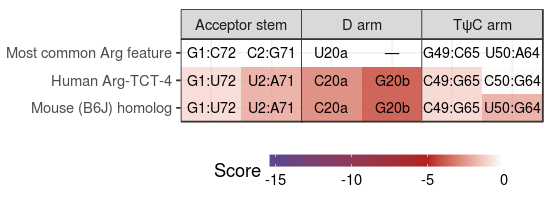

In [7]:
options(repr.plot.width = 4.6, repr.plot.height = 1.7)
plot
ggsave(plot, filename = "fig4a-ArgTCT.pdf", width = 4.6, height = 1.7, device = cairo_pdf)

In [ ]:
plot = bits %>% rowwise() %>% mutate(Identity = ifelse(Consensus == Identity, "", paste(Identity)), Bits = ifelse(Identity == "", 0, Bits)) %>%
  rbind(bits %>% 
          filter(tRNA == tRNA[1]) %>%
          mutate(Identity = Consensus, Bits = 0, tRNA = "Most common Arg feature")) %>%
  mutate(tRNA = factor(tRNA, levels = rev(c("Most common Arg feature", "Human Arg-TCT-1", "Human Arg-TCT-2", "Human Arg-TCT-3", "Human Arg-TCT-4", "Chimp", "Mouse (B6J) homolog", "Lizard", "Frog", "Lamprey", "Zebrafish", "Sea urchin", "Drosophila")))) %>%
  plot_bitchart + theme(axis.text.y = element_text(color = c("gray30", "gray30", "red", "red", "red", "red", "red", "red", "gray30", "gray30", "gray30", "gray30", "gray30")))

In [ ]:
options(repr.plot.width = 16, repr.plot.height = 5)
plot
ggsave(plot, filename = "figS5a-ArgTCT.pdf", width = 16, height = 5, device = cairo_pdf)

# Glu-TTC-5-1

In [75]:
bits = calculate_scores_multiseq(seqs = c('Glu-TTC-5' = 'GCGTTGGTGGTGTAGTGGTgAGCACAGCTGCCTTTCAAGCAGTTAACGCGGGTTCGATTCCCGGGTAACGAA'), clade = "", isotype = "Glu", anticodon = "") %>%
  mutate(tRNA = 'Glu-TTC-5 (Glu CM)')
bits = bits %>% rowwise %>% mutate(Bits = ifelse(Identity == "", 0, Bits)) %>% 
  rbind(bits %>% filter(tRNA == tRNA[1]) %>% 
  mutate(Identity = Consensus, Bits = 0, tRNA = "Most common Glu feature"))
bits2 = calculate_scores_multiseq(seqs = c('Glu-TTC-5' = 'GCGTTGGTGGTGTAGTGGTgAGCACAGCTGCCTTTCAAGCAGTTAACGCGGGTTCGATTCCCGGGTAACGAA'), clade = "", isotype = "Gly", anticodon = "") %>%
  mutate(tRNA = 'Glu-TTC-5 (Gly CM)')
bits2 = bits2 %>% rowwise %>% mutate(Bits = ifelse(Identity == "", 0, Bits)) %>%
    rbind(bits2 %>% filter(tRNA == tRNA[1]) %>% mutate(Identity = Consensus, Bits = 0, tRNA = "Most common Gly feature"))

bits = bits %>% rbind(bits2) %>%
  mutate(tRNA = factor(tRNA, levels = rev(c("Most common Glu feature", "Most common Gly feature", "Glu-TTC-5 (Glu CM)", "Glu-TTC-5 (Gly CM)")))) %>%
  filter(Position %in% c("1:72", "3:70", "4:69", "6:67", "7:66", "20a", '26', '27:43', '29:41', '31:39', '38', '44', '45', '46'))

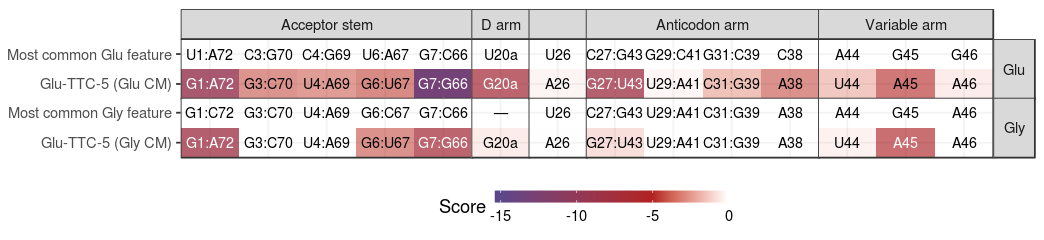

In [76]:
options(repr.plot.width = 8.7, repr.plot.height = 2.0)
plot = bits %>% mutate(Bits = ifelse(Bits > 0, 0, ifelse(Bits < -15, -15, Bits))) %>% # normalize tRNA scores to 0 (max) and -15 (min)
  mutate(Mash = mash_feature(Position, Identity)) %>%
  mutate(Identity = Mash) %>% select(-Mash) %>%
  mutate(Region = factor(regions[Position], levels = c("Acceptor stem", " ", "D arm", "  ", "Anticodon arm", "Variable arm", sprintf("T\u03c8C arm"), '   '))) %>%
  ggplot() + geom_tile(aes(x = Position, y = tRNA, fill = Bits, alpha = -Bits)) +
    geom_text(aes(x = Position, y = tRNA, label = Identity, color = ifelse(Bits < -5, "white", "black")), size = 3) +
    facet_grid(Isotype ~ Region, scales = 'free', space = 'free') +
    scale_fill_gradientn(colors = c("mediumpurple4", "firebrick", "white"),
                         values = c(0, 2/3, 1),
                         limits = c(-15, 0)) +
    scale_color_manual(values = c("black" = "black", "white" = "white")) +
    scale_x_discrete(expand = c(0, 0)) +
    scale_y_discrete(expand = c(0, 0)) +
    scale_alpha(range = c(0.4, 1)) +
    theme(axis.text.x = element_blank(),
          axis.ticks.x = element_blank(),
          axis.title = element_blank(),
          panel.spacing = unit(-0.05, "lines"),
          strip.text.y = element_text(angle = 0),
          legend.key.height = unit(0.5, "lines"),
          legend.position = "bottom") + 
    guides(alpha = FALSE, color = FALSE, fill = guide_colorbar(title = "Score", barwidth = 10))
plot
ggsave(plot, filename = "fig4b-GluTTC.pdf", width = 8.7, height = 2.0, device = cairo_pdf)

In [71]:
bits = calculate_scores_multiseq(seqs = c('Glu-CTC-1' = 'TCCCTGGTGGTCTAGTGGTtAGGATTCGGCGCTCTCACCGCCGCGGCCCGGGTTCGATTCCCGGTCAGGGAA',
                                          'Glu-TTC-1' = 'TCCCATATGGTCTAGCGGTtAGGATTCCTGGTTTTCACCCAGGTGGCCCGGGTTCGACTCCCGGTATGGGAA', 
                                          'Glu-TTC-2' = 'TCCCACATGGTCTAGCGGTtAGGATTCCTGGTTTTCACCCAGGCGGCCCGGGTTCGACTCCCGGTGTGGGAA', 
                                          'Glu-TTC-3' = 'TCCCTGGTGGTCTAGTGGCtAGGATTCGGCGCTTTCACCGCCGCGGCCCGGGTTCGATTCCCGGCCAGGGAA', 
                                          'Glu-TTC-5' = 'GCGTTGGTGGTGTAGTGGTgAGCACAGCTGCCTTTCAAGCAGTTAACGCGGGTTCGATTCCCGGGTAACGAA',
                                          'Gly-TCC-2' = 'GCGTTGGTGGTATAGTGGTgAGCATAGCTGCCTTCCAAGCAGTTGACCCGGGTTCGATTCCCGGCCAACGCA'),
  clade = "", isotype = "Glu", anticodon = "")

In [72]:
plot = bits %>% rowwise() %>% mutate(Identity = ifelse(Consensus == Identity, "", paste(Identity)), Bits = ifelse(Identity == "", 0, Bits)) %>%
  rbind(bits %>% 
          filter(tRNA == tRNA[1]) %>%
          mutate(Identity = Consensus, Bits = 0, tRNA = "Most common Glu feature")) %>%
  mutate(tRNA = factor(tRNA, levels = rev(c("Most common Glu feature", unique(bits$tRNA))))) %>%
  plot_bitchart + theme(axis.text.y = element_text(color = c("gray30", "red", "gray30", "gray30", "gray30", "gray30", "gray30")))

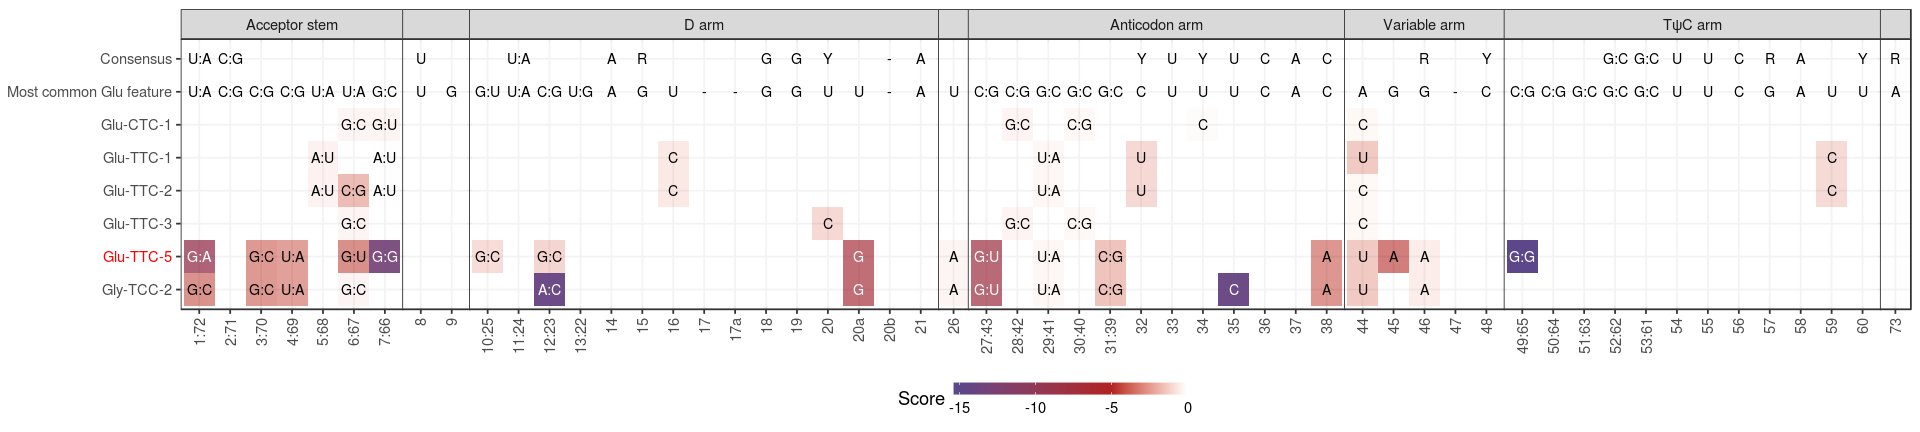

In [73]:
options(repr.plot.width=16, repr.plot.height=3.6)
plot
ggsave(plot, filename = "figS5b-GluTTC.pdf", width = 16, height = 3.6, device = cairo_pdf)

# Ser-GCT-6-1

In [63]:
bits = calculate_scores_multiseq(seqs = c('Ser-GCT-1' = 'GACGAGGTGGCCGAGTGGTtAAGGCGATGGACTGCTAATCCATTGTGCTCTGCACGCGTGGGTTCGAATCCCACCCTCGTCG', 
                                          'Ser-GCT-2' = 'GACGAGGTGGCCGAGTGGTtAAGGCGATGGACTGCTAATCCATTGTGCTCTGCACGCGTGGGTTCGAATCCCACCTTCGTCG', 
                                          'Ser-GCT-3' = 'GACGAGGTGGCCGAGTGGTtAAGGCGATGGACTGCTAATCCATTGTGCTTTGCACGCGTGGGTTCGAATCCCATCCTCGTCG', 
                                          'Ser-GCT-6' = 'GAGAGGCCTGGCCGAGTGGTtAAGGCGATGGACTGCTAATCCATTGTGCTCTGCACGCGTGGGTTCGAATCCCATCCTCGTCG', 
                                          'Ser-GCT-6-Aligned' = 'GGAGAGGCCTGGCCGAGTGGTtAAGGCGATGGACTGCTAATCCATTGTGCTCTGCACGCGTGGGTTCGAATCCCATCCTCGTCG', 
                                          'Ser-AGA-1' = 'GTAGTCGTGGCCGAGTGGTtAAGGCGATGGACTAGAAATCCATTGGGGTTTCCCCGCGCAGGTTCGAATCCTGCCGACTACG', 
                                          'Ser-CGA-1' = 'GCTGTGATGGCCGAGTGGTtAAGGCGTTGGACTCGAAATCCAATGGGGTCTCCCCGCGCAGGTTCGAATCCTGCTCACAGCG', 
                                          'Ser-TGA-1' = 'GCAGCGATGGCCGAGTGGTtAAGGCGTTGGACTTGAAATCCAATGGGGTCTCCCCGCGCAGGTTCGAACCCTGCTCGCTGCG'),
                                clade = "", isotype = "Ser", anticodon = "")

In [64]:
plot = bits %>% rowwise() %>% mutate(Bits = ifelse(Identity == Consensus, 0, Bits)) %>%
  rbind(bits %>% 
          filter(tRNA == tRNA[1]) %>%
          mutate(Identity = Consensus, Bits = 0, tRNA = "Most common Ser feature")) %>%
  mutate(tRNA = factor(tRNA, levels = rev(c("Most common Ser feature", unique(bits$tRNA))))) %>%
  filter(tRNA %in% c("Most common Ser feature", "Ser-GCT-6", "Ser-GCT-6-Aligned")) %>%
  filter(Position %in% c("1:72", "2:71", "3:70", "4:69", "49:65")) %>% 
  # patch for -3:G70. currently, mashing doesn't work for gapped (e.g. G:-) features, because the identity is listed by the CM to be a single base (e.g., G). Will need a better solution for this later.
  mutate(Identity = ifelse(as.character(Identity) == "G", "-:G", as.character(Identity))) %>%
  plot_simple_bitchart

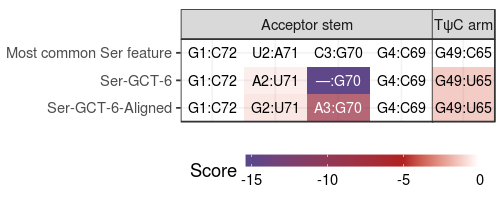

In [65]:
options(repr.plot.width = 4.2, repr.plot.height = 1.7)
plot
ggsave(plot, filename = "fig4c-SerGCT.pdf", width = 4.2, height = 1.7, device = cairo_pdf)

In [66]:
plot = bits %>% rowwise() %>% mutate(Identity = ifelse(Consensus == Identity, "", paste(Identity)), Bits = ifelse(Identity == "", 0, Bits)) %>%
  rbind(bits %>% 
          filter(tRNA == tRNA[1]) %>%
          mutate(Identity = Consensus, Bits = 0, tRNA = "Most common Ser feature")) %>%
  mutate(tRNA = factor(tRNA, levels = rev(c("Most common Ser feature", unique(bits$tRNA))))) %>%
  plot_bitchart + theme(axis.text.y = element_text(color = c("gray30", "gray30", "gray30", "red", "red", "gray30", "gray30", "gray30", "gray30", "gray30")))

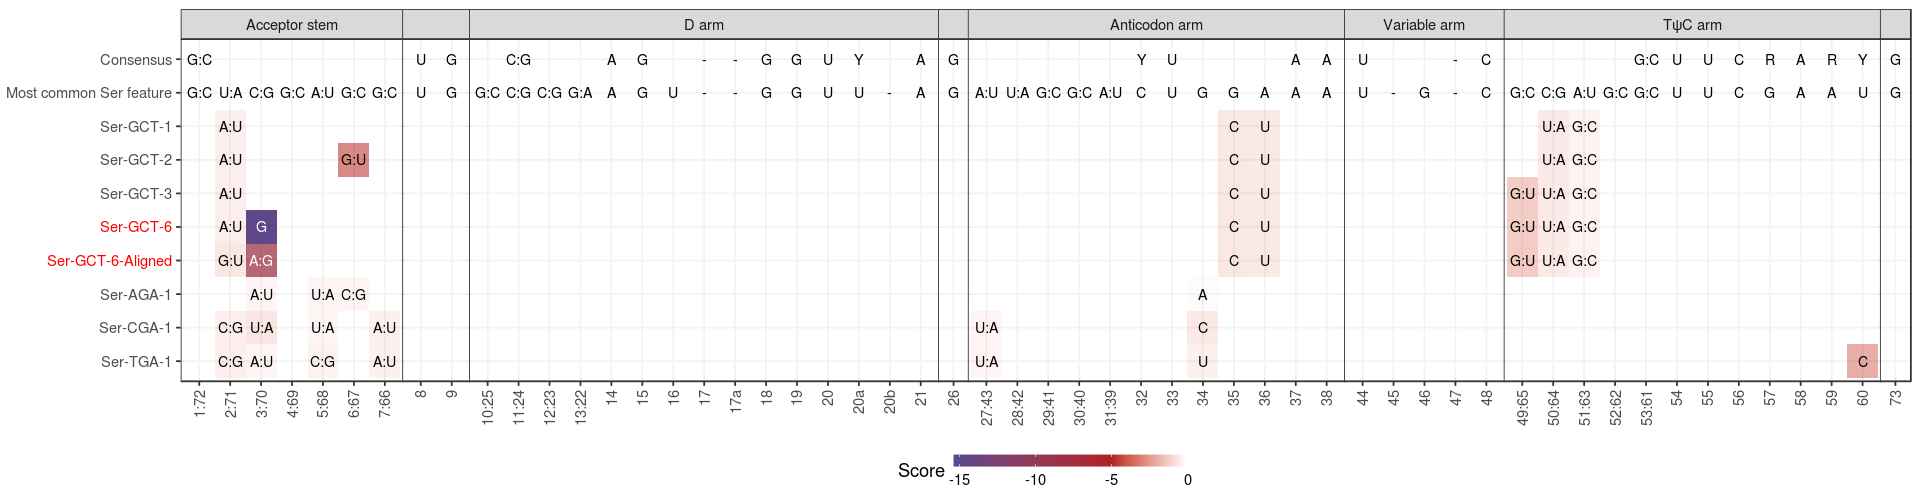

In [68]:
options(repr.plot.width=16, repr.plot.height=4.2)
plot
ggsave(plot, filename = "figS5c-SerGCT.pdf", width = 16, height = 4.2, device = cairo_pdf)

## Isotype uncertainty

In [20]:
bits = calculate_scores_multiseq(seqs = c(
"Val-AAC-6" = "GGGGGTGTAGCTCAGTGGTAGAGCGTATGCTTAACATTCATGAGGcTCTGGGTTCGATCCCCAGCACTTCCA"),
                                clade = "", isotype = "Val", anticodon = "") %>%
  mutate(tRNA = ifelse(tRNA == "Val-AAC-6", "Val-AAC-6 (Val CM)", tRNA))

bits = bits %>% rbind(calculate_scores_multiseq(seqs = c(
"Val-AAC-6" = "GGGGGTGTAGCTCAGTGGTAGAGCGTATGCTTAACATTCATGAGGcTCTGGGTTCGATCCCCAGCACTTCCA"),
                                clade = "", isotype = "Ala", anticodon = "") %>%
                       mutate(tRNA = ifelse(tRNA == "Val-AAC-6", "Val-AAC-6 (Ala CM)", tRNA)))

bits = bits %>% rowwise() %>% mutate(Bits = ifelse(Identity == "", 0, Bits)) %>%
  rbind(bits %>% 
          group_by(Isotype) %>%
          filter(tRNA == tRNA[1]) %>%
          mutate(Identity = Consensus, Bits = 0, tRNA = paste("Most common", Isotype, "feature")) %>%
          ungroup)

In [21]:
plot = bits %>% 
  mutate(Bits = ifelse(Bits > 0, 0, ifelse(Bits < -15, -15, Bits))) %>% # normalize tRNA scores to 0 (max) and -15 (min)
  mutate(Mash = mash_feature(Position, Identity)) %>%
  mutate(Identity = Mash) %>% select(-Mash) %>%
  ungroup %>%
  mutate(tRNA = factor(tRNA, levels = rev(c("Most common Val feature", "Val-AAC-6 (Val CM)", "Most common Ala feature", "Val-AAC-6 (Ala CM)")))) %>%
  mutate(Region = factor(regions[Position], levels = c("Acceptor stem", " ", "D arm", "  ", "Anticodon arm", "Variable arm", sprintf("T\u03c8C arm")))) %>%
  filter(Position %in% c("3:70", "4:69", "5:68", "6:67", "11:24", "12:23", "13:22", "20a", "27:43", "28:42", "31:39", "47", "48")) %>% 
  ggplot() + geom_tile(aes(x = Position, y = tRNA, fill = Bits, alpha = -Bits)) +
    geom_text(aes(x = Position, y = tRNA, label = Identity, color = ifelse(Bits < -5, "white", "black")), size = 3) +
    facet_grid(Isotype ~ Region, scales = 'free', space = 'free') +
    scale_fill_gradientn(colors = c("mediumpurple4", "firebrick", "white"),
                         values = c(0, 2/3, 1),
                         limits = c(-15, 0)) +
    scale_color_manual(values = c("black" = "black", "white" = "white")) +
    scale_x_discrete(expand = c(0, 0)) +
    scale_y_discrete(expand = c(0, 0)) +
    scale_alpha(range = c(0.4, 1)) +
    theme(axis.text.x = element_blank(),
          axis.ticks.x = element_blank(),
          axis.title = element_blank(),
          panel.spacing = unit(-0.05, "lines"),
          strip.text.y = element_text(angle = 0),
          legend.key.height = unit(0.5, "lines"),
          legend.position = "bottom") + 
    guides(alpha = FALSE, color = FALSE, fill = guide_colorbar(title = "Score", barwidth = 10))


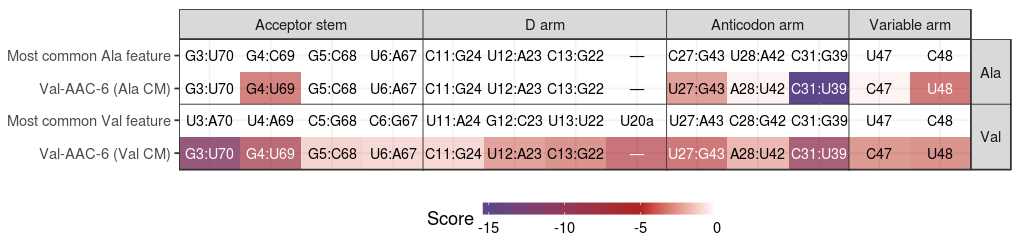

In [22]:
options(repr.plot.width = 8.5, repr.plot.height = 2.1)
plot
ggsave(plot, filename = "fig4d-ValAAC.pdf", width = 8.5, height = 2.1, device = cairo_pdf)

In [23]:
bits = calculate_scores_multiseq(seqs = c(
"Val-AAC-1" = "GTTTCCGTAGTGTAGTGGTtATCACGTTCGCCTAACACGCGAAAGGtCCCCGGTTCGAAACCGGGCGGAAACA",
"Val-CAC-1" = "GTTTCCGTAGTGTAGTGGTtATCACGTTCGCCTCACACGCGAAAGGtCCCCGGTTCGAAACCGGGCGGAAACA",
"Val-TAC-1" = "GGTTCCATAGTGTAGTGGTtATCACGTCTGCTTTACACGCAGAAGGtCCTGGGTTCGAGCCCCAGTGGAACCA",
"Val-TAC-2" = "GGTTCCATAGTGTAGCGGTtATCACGTCTGCTTTACACGCAGAAGGtCCTGGGTTCGAGCCCCAGTGGAACCA",
"Val-AAC-6" = "GGGGGTGTAGCTCAGTGGTAGAGCGTATGCTTAACATTCATGAGGcTCTGGGTTCGATCCCCAGCACTTCCA"),
                                clade = "", isotype = "Val", anticodon = "")

In [24]:
plot = bits %>% rowwise() %>% mutate(Identity = ifelse(Consensus == Identity, "", paste(Identity)), Bits = ifelse(Identity == "", 0, Bits)) %>%
  rbind(bits %>% 
          filter(tRNA == tRNA[1]) %>%
          mutate(Identity = Consensus, Bits = 0, tRNA = "Most common Val feature")) %>%
  mutate(tRNA = factor(tRNA, levels = rev(c("Most common Val feature", unique(bits$tRNA))))) %>%
  plot_bitchart + theme(axis.text.y = element_text(color = c("red", "gray30", "gray30", "gray30", "gray30", "gray30", "gray30", "gray30", "gray30")))

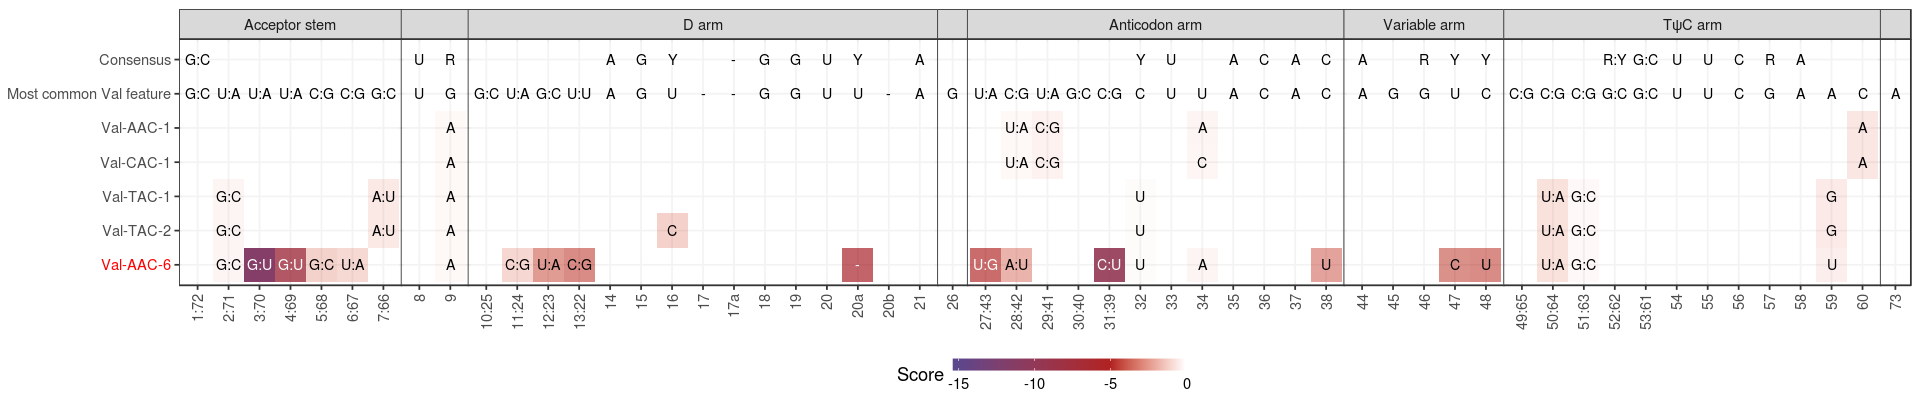

In [25]:
options(repr.plot.width=16, repr.plot.height=3.4)
plot
ggsave(plot, filename = "figS5d-ValAAC-Val.pdf", width = 16, height = 3.4, device = cairo_pdf)

In [26]:
bits = calculate_scores_multiseq(seqs = c(
"Ala-AGC-1" = "GGGGGTATAGCTCAGTGGTAGAGCGCGTGCTTAGCATGCACGAGGtCCTGGGTTCGATCCCCAGTACCTCCA",
"Ala-AGC-2" = "GGGGGTGTAGCTCAGTGGTAGAGCGCGTGCTTAGCATGCACGAGGcCCCGGGTTCAATCCCCGGCACCTCCA",
"Ala-AGC-3" = "GGGGGTGTAGCTCAGTGGTAGAGCGCGTGCTTAGCATGTACGAGGtCCCGGGTTCAATCCCCGGCACCTCCA",
"Ala-AGC-5" = "GGGGGTGTAGCTCAGTGGTAGAGCGCGTGCTTAGCATGCACGAGGcCCTGGGTTCAATCCCCAGCACCTCCA",
"Val-AAC-6" = "GGGGGTGTAGCTCAGTGGTAGAGCGTATGCTTAACATTCATGAGGcTCTGGGTTCGATCCCCAGCACTTCCA"),
                                clade = "", isotype = "Ala", anticodon = "")

In [27]:
plot = bits %>% rowwise() %>% mutate(Identity = ifelse(Consensus == Identity, "", paste(Identity)), Bits = ifelse(Identity == "", 0, Bits)) %>%
  rbind(bits %>% 
          filter(tRNA == tRNA[1]) %>%
          mutate(Identity = Consensus, Bits = 0, tRNA = "Most common Ala feature")) %>%
  mutate(tRNA = factor(tRNA, levels = rev(c("Most common Ala feature", unique(bits$tRNA))))) %>%
  plot_bitchart + theme(axis.text.y = element_text(color = c("red", "gray30", "gray30", "gray30", "gray30", "gray30", "gray30", "gray30", "gray30")))

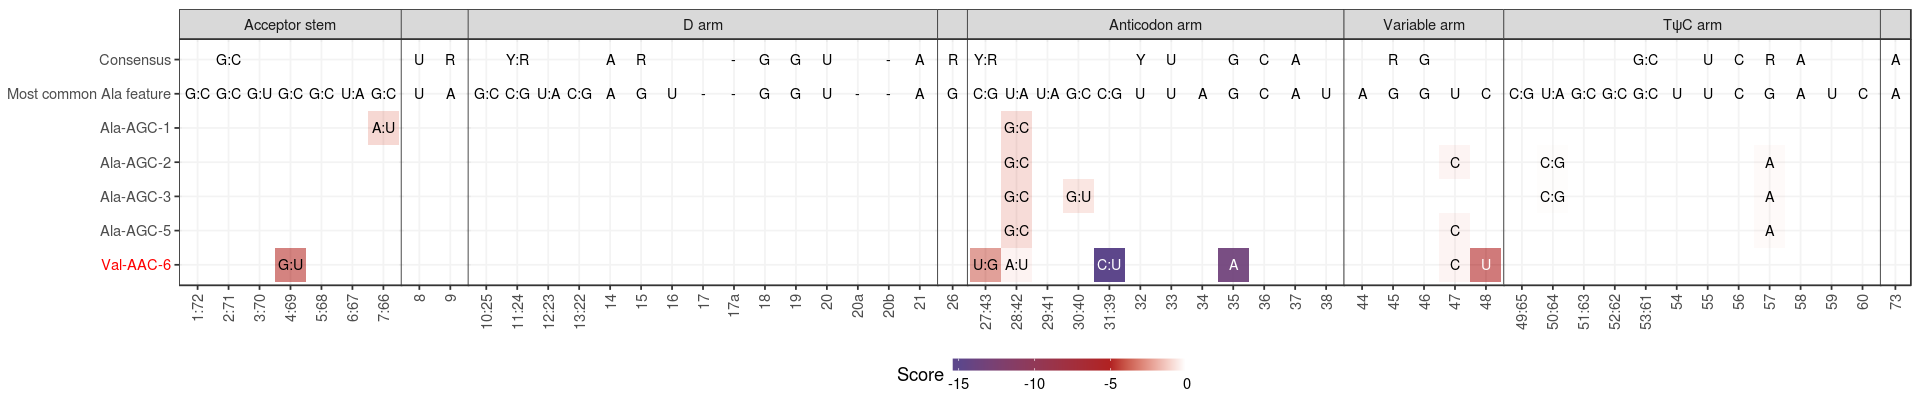

In [28]:
options(repr.plot.width=16, repr.plot.height=3.4)
plot
ggsave(plot, filename = "figS5e-ValAAC-Ala.pdf", width = 16, height = 3.4, device = cairo_pdf)

# tDRs acting as miRNAs

## Gly-GCC-2 / CU1276

Fragment processing indicates that Gly-GCC-2 is cut in the D loop between position 54 and 55. Leader/trailer sequences do not pair at all.

In [29]:
bits = calculate_scores_multiseq(seqs = c('Gly-GCC-1' = 'GCATGGGTGGTTCAGTGGTAGAATTCTCGCCTGCCACGCGGGAGGCCCGGGTTCGATTCCCGGCCCATGCA',
                                          'Gly-GCC-2' = 'GCATTGGTGGTTCAGTGGTAGAATTCTCGCCTGCCACGCGGGAGGCCCGGGTTCGATTCCCGGCCAATGCA',
                                          'Gly-GCC-3' = 'GCATTGGTGGTTCAGTGGTAGAATTCTCGCCTGCCACGCGGGAGGCCCGGGTTTGATTCCCGGCCAGTGCA',
                                          'Gly-GCC-4' = 'GCATAGGTGGTTCAGTGGTAGAATTCTTGCCTGCCACGCAGGAGGCCCAGGTTTGATTCCTGGCCCATGCA',
                                          'Gly-CCC-1' = 'GCATTGGTGGTTCAGTGGTAGAATTCTCGCCTCCCACGCGGGAGACCCGGGTTCAATTCCCGGCCAATGCA',
                                          'Gly-CCC-2' = 'GCGCCGCTGGTGTAGTGGTATCATGCAAGATTCCCATTCTTGCGACCCGGGTTCGATTCCCGGGCGGCGCA',
                                          'Gly-TCC-1' = 'GCGTTGGTGGTATAGTGGTtAGCATAGCTGCCTTCCAAGCAGTTGACCCGGGTTCGATTCCCGGCCAACGCA',
                                          'Gly-TCC-2' = 'GCGTTGGTGGTATAGTGGTgAGCATAGCTGCCTTCCAAGCAGTTGACCCGGGTTCGATTCCCGGCCAACGCA'),
  clade = "", isotype = "Gly", anticodon = "")

In [30]:
plot = bits %>% rowwise() %>% mutate(Identity = ifelse(Consensus == Identity, "", paste(Identity)), Bits = ifelse(Identity == "", 0, Bits)) %>%
  rbind(bits %>% 
          filter(tRNA == tRNA[1]) %>%
          mutate(Identity = Consensus, Bits = 0, tRNA = "Most common Gly features")) %>%
  mutate(tRNA = factor(tRNA, levels = rev(c("Most common Gly features", unique(bits$tRNA))))) %>%
  plot_bitchart + theme(axis.text.y = element_text(color = c("gray30", "gray30", "gray30", "gray30", "gray30", "gray30", "red", "gray30", "gray30")))

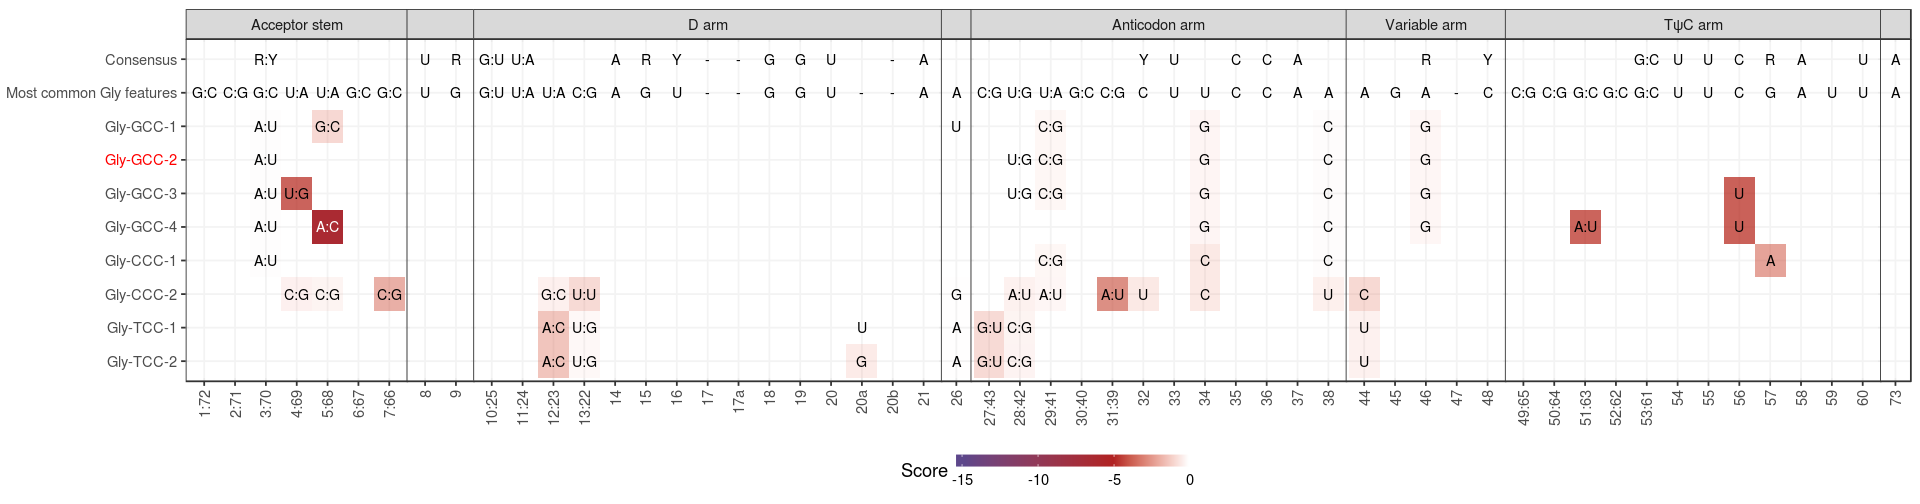

In [31]:
options(repr.plot.width=16, repr.plot.height=4.2)
plot
ggsave(plot, filename = "figS5f-GlyGCC.pdf", width = 16, height = 4.2, device = cairo_pdf)

## Thr-AGT-1-1 (mir-3676)

Fragment processing indicates that Thr-AGT-1-1 is cut in the D loop between position 19 and 20. Leader/trailer sequences pair somewhat:

```
Trailer   TTTCGCACCCCCTTTGTGCC A73  -- tRNA
                         | |||
Leader    ATCCTAAGCGTCTTTC-CGG  C  -- tRNA
```


In [32]:
bits = calculate_scores_multiseq(seqs = c('Thr-AGT-1' = 'GGCGCCGTGGCTTAGTTGGTtAAAGCGCCTGTCTAGTAAACAGGAGAtCCTGGGTTCGAATCCCAGCGGTGCCT', 
                                          'Thr-AGT-2' = 'GGCTCCGTGGCTTAGCTGGTtAAAGCGCCTGTCTAGTAAACAGGAGAtCCTGGGTTCGAATCCCAGCGGGGCCT', 
                                          'Thr-AGT-3' = 'GGCTCCGTAGCTTAGTTGGTtAAAGCGCCTGTCTAGTAAACAGGAGAtCCTGGGTTCGACTCCCAGCGGGGCCT', 
                                          'Thr-AGT-4' = 'GGCTTCGTGGCTTAGCTGGTtAAAGCGCCTGTCTAGTAAACAGGAGAtCCTGGGTTCGAATCCCAGCGAGGCCT', 
                                          'Thr-AGT-5' = 'GGCGCCGTGGCTTAGCTGGTtAAAGCGCCTGTCTAGTAAACAGGAGAtCCTGGGTTCGAATCCCAGCGGTGCCT', 
                                          'Thr-AGT-6' = 'GGCCCTGTGGCTTAGCTGGTcAAAGCGCCTGTCTAGTAAACAGGAGAtCCTGGGTTCGAATCCCAGCGGGGCCT', 
                                          'Thr-CGT-1' = 'GGCTCTATGGCTTAGTTGGTtAAAGCGCCTGTCTCGTAAACAGGAGAtCCTGGGTTCGACTCCCAGTGGGGCCT', 
                                          'Thr-CGT-2' = 'GGCGCGGTGGCCAAGTGGTAAGGCGTCGGTCTCGTAAACCGAAGAtCACGGGTTCGAACCCCGTCCGTGCCT', 
                                          'Thr-TGT-1' = 'GGCTCTATGGCTTAGTTGGTtAAAGCGCCTGTCTTGTAAACAGGAGAtCCTGGGTTCGAATCCCAGTAGAGCCT'), 
  clade = "", isotype = "Thr", anticodon = "")

In [33]:
plot = bits %>% rowwise() %>% mutate(Identity = ifelse(Consensus == Identity, "", paste(Identity)), Bits = ifelse(Identity == "", 0, Bits)) %>%
  rbind(bits %>% 
          filter(tRNA == tRNA[1]) %>%
          mutate(Identity = Consensus, Bits = 0, tRNA = "Most common Thr features")) %>%
  mutate(tRNA = factor(tRNA, levels = rev(c("Most common Thr features", unique(bits$tRNA))))) %>%
  plot_bitchart + theme(axis.text.y = element_text(color = c("gray30", "gray30", "gray30", "gray30", "gray30", "gray30", "gray30", "gray30", "red", "gray30")))

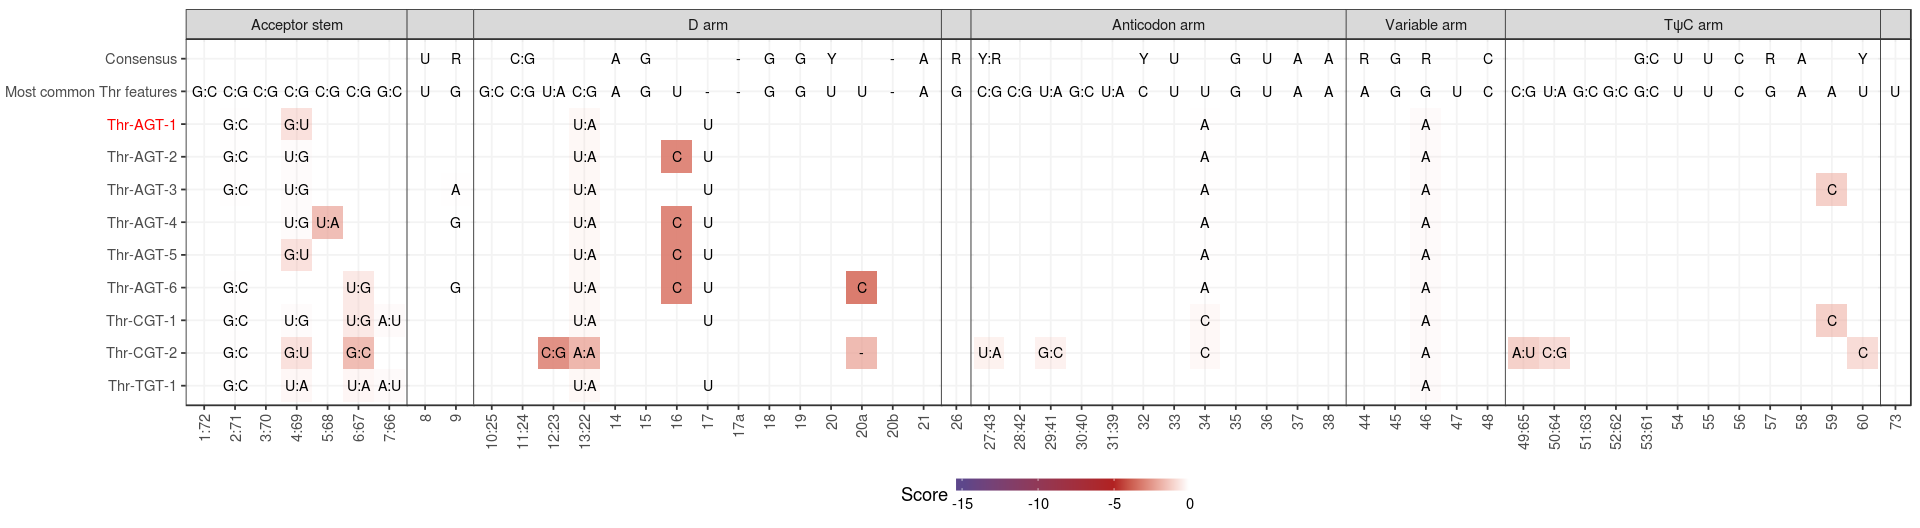

In [34]:
options(repr.plot.width=16, repr.plot.height=4.4)
plot
ggsave(plot, filename = "figS5g-ThrAGT.pdf", width = 16, height = 4.4, device = cairo_pdf)

## Gln-CTG

In [35]:
bits = calculate_scores_multiseq(seqs = c('Gln-CTG-1' = 'GGTTCCATGGTGTAATGGTtAGCACTCTGGACTCTGAATCCAGCGATCCGAGTTCAAATCTCGGTGGAACCT',
                                          'Gln-CTG-2' = 'GGTTCCATGGTGTAATGGTtAGCACTCTGGACTCTGAATCCAGCGATCCGAGTTCAAGTCTCGGTGGAACCT',
                                          'Gln-CTG-3' = 'GGTTCCATGGTGTAATGGTgAGCACTCTGGACTCTGAATCCAGCGATCCGAGTTCGAGTCTCGGTGGAACCT',
                                          'Gln-CTG-4' = 'GGTTCCATGGTGTAATGGTaAGCACTCTGGACTCTGAATCCAGCGATCCGAGTTCGAGTCTCGGTGGAACCT',
                                          'Gln-CTG-5' = 'GGTTCCATGGTGTAATGGTtAGCACTCTGGACTCTGAATCCGGTAATCCGAGTTCAAATCTCGGTGGAACCT',
                                          'Gln-CTG-6' = 'GGCCCCATGGTGTAATGGTcAGCACTCTGGACTCTGAATCCAGCGATCCGAGTTCAAATCTCGGTGGGACCC',
                                          'Gln-TTG-1' = 'GGTCCCATGGTGTAATGGTtAGCACTCTGGACTTTGAATCCAGCGATCCGAGTTCAAATCTCGGTGGGACCT'), 
                                 clade = "", isotype = "Gln", anticodon = "")

In [36]:
plot = bits %>% rowwise() %>% mutate(Identity = ifelse(Consensus == Identity, "", paste(Identity)), Bits = ifelse(Identity == "", 0, Bits)) %>%
  rbind(bits %>% 
          filter(tRNA == tRNA[1]) %>%
          mutate(Identity = Consensus, Bits = 0, tRNA = "Most common Gln features")) %>%
  mutate(tRNA = factor(tRNA, levels = rev(c("Most common Gln features", unique(bits$tRNA))))) %>%
  plot_bitchart + theme(axis.text.y = element_text(color = c("gray30", "gray30", "gray30", "gray30", "gray30", "gray30", "red", "gray30")))

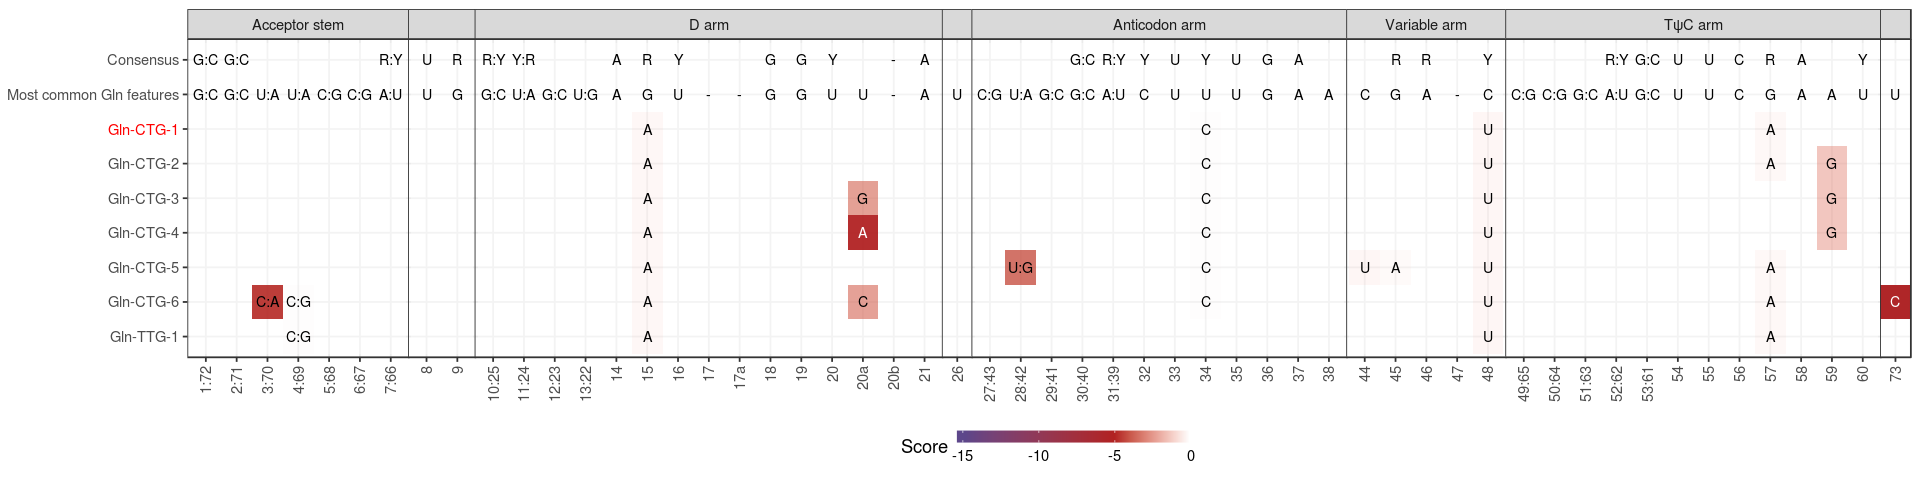

In [37]:
options(repr.plot.width=16, repr.plot.height=4)
plot
ggsave(plot, filename = "figS5h-GlnCTG.pdf", width = 16, height = 4, device = cairo_pdf)

## Cys-GCA (cand20)

In [38]:
bits = calculate_scores_multiseq(seqs = c('Cys-GCA-1' = 'GGGGGCATAGCTCAGTGGTAGAGCATTTGACTGCAGATCAAGAGGtCCCTGGTTCAAATCCAGGTGCCCCCT',
                                          'Cys-GCA-2' = 'GGGGGTATAGCTCAGTGGTAGAGCATTTGACTGCAGATCAAGAGGtCCCCGGTTCAAATCCGGGTGCCCCCT',
                                          'Cys-GCA-4' = 'GGGGGTATAGCTCAGTGGTAGAGCATTTGACTGCAGATCAAGAGGtCCCTGGTTCAAATCCGGGTGCCCCCT',
                                          'Cys-GCA-5' = 'GGGGGTATAGCTCAGTGGGtAGAGCATTTGACTGCAGATCAAGAGGtCCCCGGTTCAAATCCGGGTGCCCCCT',
                                          'Cys-GCA-7' = 'GGGGGTATAGCTCAGGTGGTAGAGCATTTGACTGCAGATCAAGAGGtCCCCGGTTCAAATCCGGGTGCCCCCT',
                                          'Cys-GCA-8' = 'GGGGGTATAGCTCAGGGGTAGAGCATTTGACTGCAGATCAAGAGGtCCCCGGTTCAAATCCGGGTGCCCCCT',
                                          'Cys-GCA-11' = 'GGGGGTATAGCTTAGCGGTAGAGCATTTGACTGCAGATCAAGAGGtCCCCGGTTCAAATCCGGGTGCCCCCT',
                                          'Cys-GCA-14' = 'GGGGGTATAGCTCAGGGGTAGAGCATTTGACTGCAGATCAAGAAGtCCCCGGTTCAAATCCGGGTGCCCCCT'),
                                 clade = "", isotype = "Cys", anticodon = "")

In [39]:
plot = bits %>% rowwise() %>% mutate(Identity = ifelse(Consensus == Identity, "", paste(Identity)), Bits = ifelse(Identity == "", 0, Bits)) %>%
  rbind(bits %>% 
          filter(tRNA == tRNA[1]) %>%
          mutate(Identity = Consensus, Bits = 0, tRNA = "Most common Cys features")) %>%
  mutate(tRNA = factor(tRNA, levels = rev(c("Most common Cys features", unique(bits$tRNA))))) %>%
  plot_bitchart + theme(axis.text.y = element_text(color = c("red", "red", "red", "red", "red", "red", "red", "red", "gray30", "gray30", "gray30")))

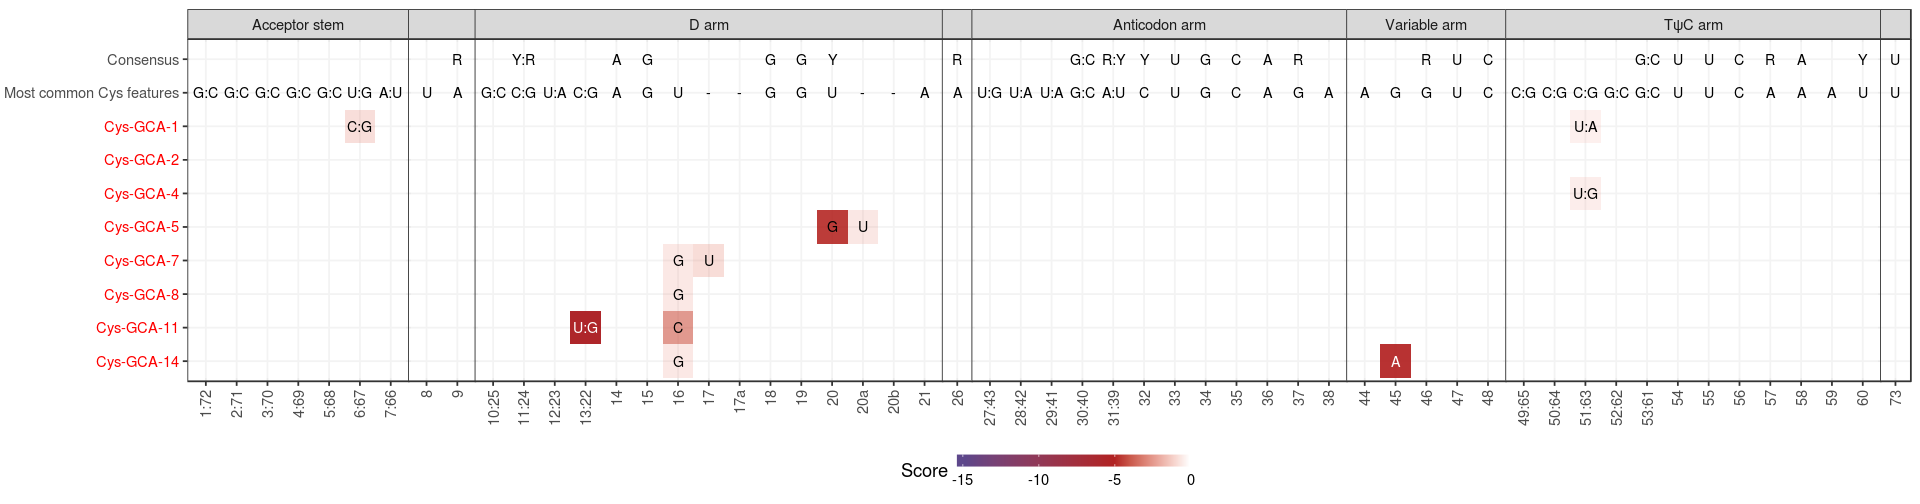

In [40]:
options(repr.plot.width=16, repr.plot.height=4.2)
plot
ggsave(plot, filename = "figS5k-CysGCA.pdf", width = 16, height = 4.2, device = cairo_pdf)

# Pro-CGG-2-1 and Ile-TAT-2-3 (Hasler et al. 2016)

These tRNAs are known to pair leader/trailer sequences.

In [41]:
bits = calculate_scores_multiseq(seqs = c(
"Pro-AGG-1" = "GGCTCGTTGGTCTAGGGGTATGATTCTCGCTTAGGATGCGAGAGGtCCCGGGTTCAAATCCCGGACGAGCCC",
"Pro-AGG-2" = "GGCTCGTTGGTCTAGGGGTATGATTCTCGCTTAGGGTGCGAGAGGtCCCGGGTTCAAATCCCGGACGAGCCC",
"Pro-TGG-1" = "GGCTCGTTGGTCTAGTGGTATGATTCTCGCTTTGGGTGCGAGAGGtCCCGGGTTCAAATCCCGGACGAGCCC",
"Pro-TGG-2" = "GGCTCGTTGGTCTAGGGGTATGATTCTCGGTTTGGGTCCGAGAGGtCCCGGGTTCAAATCCCGGACGAGCCC",
"Pro-CGG-1" = "GGCTCGTTGGTCTAGGGGTATGATTCTCGCTTCGGGTGCGAGAGGtCCCGGGTTCAAATCCCGGACGAGCCC",
"Pro-CGG-2" = "GGCTCGTTGGTCTAGGGGTATGATTCTCGCTTCGGGTGTGAGAGGtCCCGGGTTCAAATCCCGGACGAGCCC"),
  clade = "", isotype = "Pro", anticodon = "")

In [42]:
plot = bits %>% rowwise() %>% mutate(Identity = ifelse(Consensus == Identity, "", paste(Identity)), Bits = ifelse(Identity == "", 0, Bits)) %>%
  rbind(bits %>% 
          filter(tRNA == tRNA[1]) %>%
          mutate(Identity = Consensus, Bits = 0, tRNA = "Most common Pro features")) %>%
  mutate(tRNA = factor(tRNA, levels = rev(c("Most common Pro features", unique(bits$tRNA))))) %>%
  plot_bitchart + theme(axis.text.y = element_text(color = c("red", "gray30", "gray30", "gray30", "gray30", "gray30", "gray30", "gray30", "gray30")))

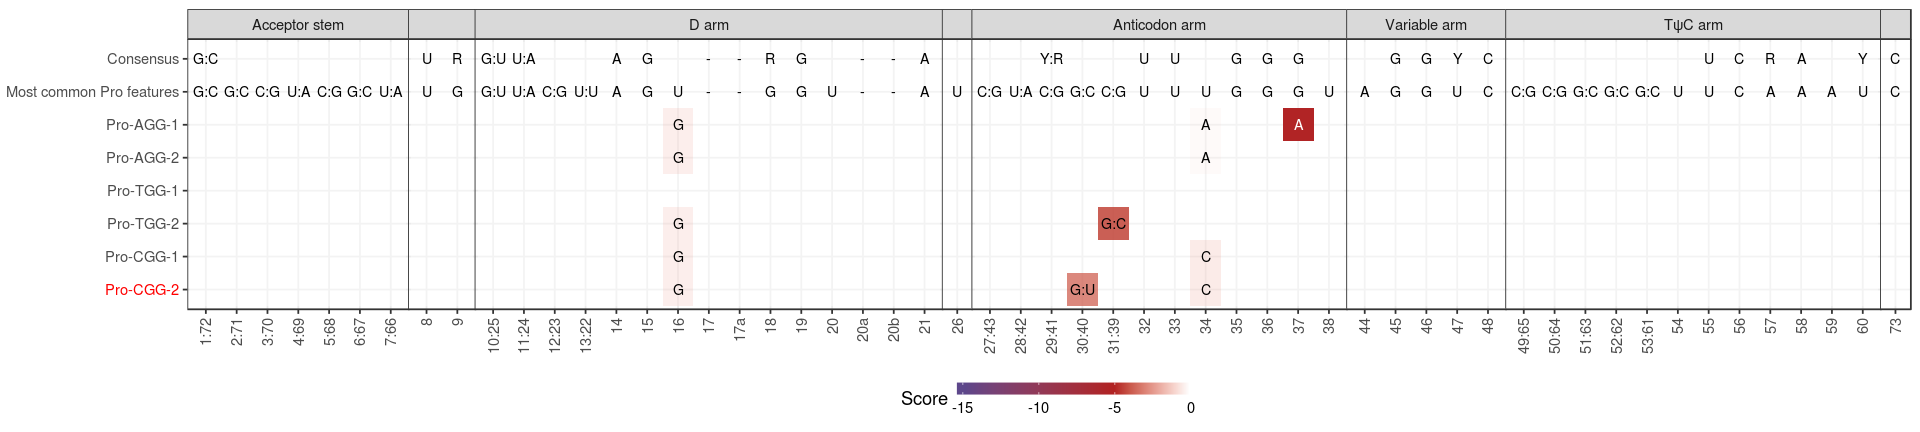

In [43]:
options(repr.plot.width=16, repr.plot.height=3.6)
plot
ggsave(plot, filename = "figS5i-ProCGG.pdf", width = 16, height = 3.6, device = cairo_pdf)

In [44]:
bits = calculate_scores_multiseq(seqs = c("Ile-TAT-1" = "GCTCCAGTGGCGCAATCGGTtAGCGCGCGGTACTTATAtgacagtgcgagcggagcaATGCCGAGGtTGTGAGTTCGATCCTCACCTGGAGCA",
                                          "Ile-TAT-2" = "GCTCCAGTGGCGCAATCGGTtAGCGCGCGGTACTTATAcagcagtacatgcagagcaATGCCGAGGtTGTGAGTTCGAGCCTCACCTGGAGCA",
                                          "Ile-TAT-3" = "GCTCCAGTGGCGCAATCGGTtAGCGCGCGGTACTTATAagacagtgcacctgtgagcaATGCCGAGGtTGTGAGTTCAAGCCTCACCTGGAGCA",
                                          'Ile-AAT-2' = 'GGCCGGTTAGCTCAGTTGGTtAGAGCGTGGTGCTAATAACGCCAAGGtCGCGGGTTCGATCCCCGTACTGGCCA',
                                          'Ile-AAT-1' = 'GGCCGGTTAGCTCAGTTGGTtAGAGCGTGGCGCTAATAACGCCAAGGtCGCGGGTTCGATCCCCGTACGGGCCA',
                                          'Ile-GAT-1' = 'GGCCGGTTAGCTCAGTTGGTaAGAGCGTGGTGCTGATAACACCAAGGtCGCGGGCTCGACTCCCGCACCGGCCA'),
                                clade = "", isotype = "Ile", anticodon = "")

In [45]:
plot = bits %>% rowwise() %>% mutate(Identity = ifelse(Consensus == Identity, "", paste(Identity)), Bits = ifelse(Identity == "", 0, Bits)) %>%
  rbind(bits %>% 
          filter(tRNA == tRNA[1]) %>%
          mutate(Identity = Consensus, Bits = 0, tRNA = "Most common Ile features")) %>%
  mutate(tRNA = factor(tRNA, levels = rev(c("Most common Ile features", unique(bits$tRNA))))) %>%
  plot_bitchart + theme(axis.text.y = element_text(color = c("gray30", "gray30", "gray30", "gray30", "red", "gray30", "gray30")))

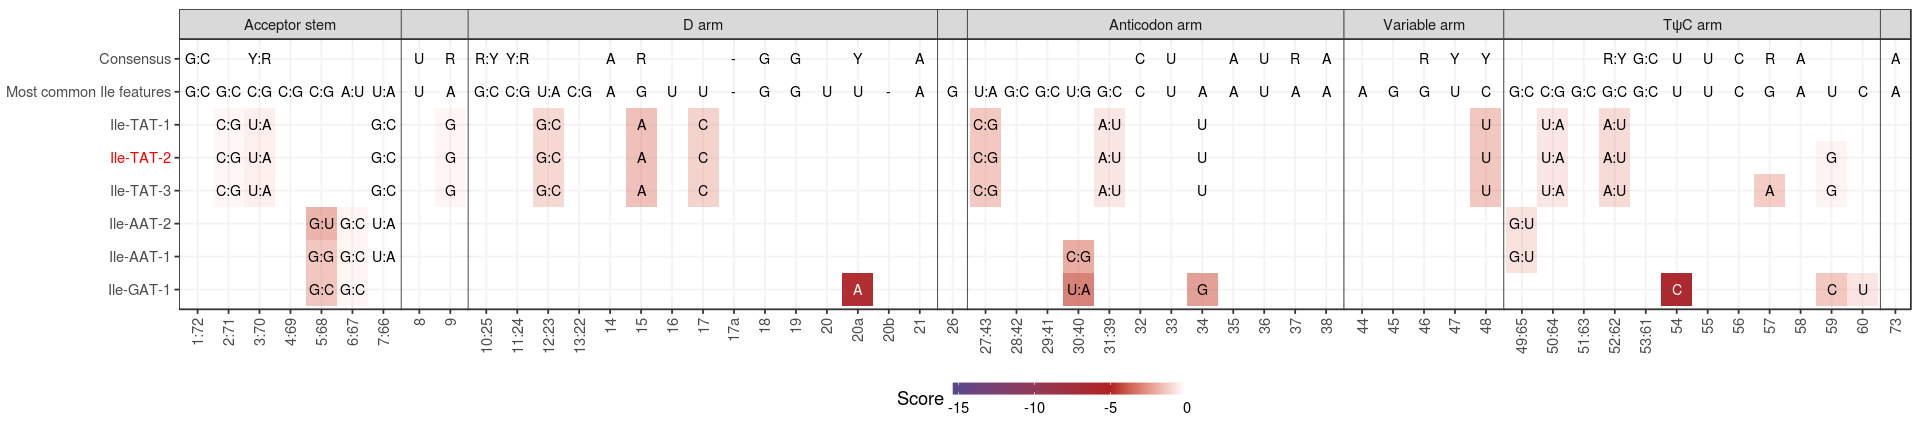

In [46]:
options(repr.plot.width=16, repr.plot.height=3.6)
plot
ggsave(plot, filename = "figS5j-IleTAT.pdf", width = 16, height = 3.6, device = cairo_pdf)

<img src="http://gtrnadb.ucsc.edu/genomes/eukaryota/Hsapi19/images/hg19-chr2.tRNA5-IleTAT.gif" style='width:200px;display:inline'>
<img src="http://gtrnadb.ucsc.edu/genomes/eukaryota/Hsapi19/images_MFE/hg19-tRNA-Ile-TAT-2-1-MFE.gif" style='width:200px;display:inline'>

## Nev-tRNA example

In [47]:
bits = calculate_scores_multiseq(seqs = c(
"Gly-GCC-1" = "GCATCGGTGGTTCAGTGGTAGAATGCTCGCCTGCCACGCGGGCGGCCCGGGTTCGATTCCCGGTCGATGCA",
"Gly-GCC-2" = "GCATCGGTGGTTCAGTGGTAGAATGCTCGCCTGCCACGCGTGCGGCCCGGGTTCGATTCCCGGTCGATGCA",
"Gly-TCC-1" = "GCGTTCGTGGTGTAATGGTcAGCATGGATGCCTTCCAAGCATTCGACGGGGGTTCGATTCCCCCCGAACGCA",
"Gly-TCC-2" = "GCGTTCGTGGTGTAATGGTcAGCATGGATGCCTTCCAAGCATTCGACGGGGGTTCGATTCCCCTCGAACGCA",
"Gly-CCC-1" = "GCGGTGGTGGCCGAGCGGTcAAGGCGTAGGACTCCCGATCCTATTCTGGTAACAGAGCGCGGGTTCGAATCCCGTCCACCGCA"),
                                clade = "", isotype = "Gly", anticodon = "")

In [48]:
plot = bits %>% rowwise() %>% mutate(Identity = ifelse(Consensus == Identity, "", paste(Identity)), Bits = ifelse(Identity == "", 0, Bits)) %>%
  rbind(bits %>% 
          filter(tRNA == tRNA[1]) %>%
          mutate(Identity = Consensus, Bits = 0, tRNA = "Most common Gly features")) %>%
  mutate(tRNA = factor(tRNA, levels = rev(c("Most common Gly features", unique(bits$tRNA))))) %>%
  plot_bitchart + theme(axis.text.y = element_text(color = c("red", "gray30", "gray30", "gray30", "gray30", "gray30", "gray30", "gray30", "gray30")))

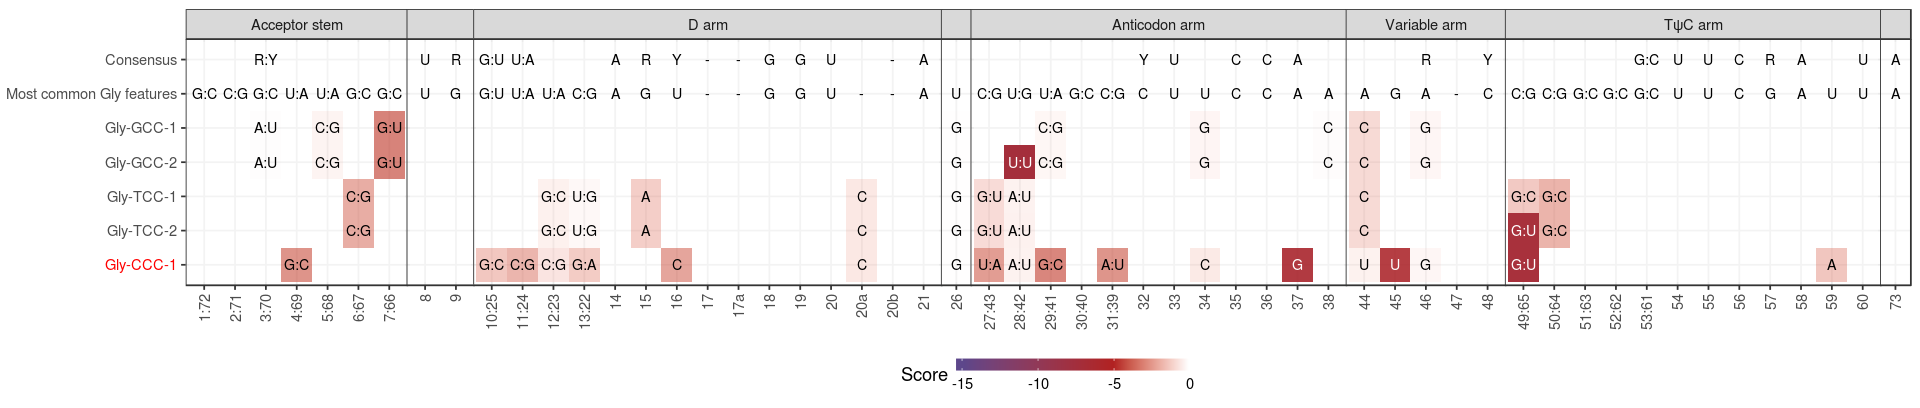

In [49]:
options(repr.plot.width=16, repr.plot.height=3.4)
plot
ggsave(plot, filename = "figS5l-ce-GlyCCC-Gly.pdf", width = 16, height = 3.4, device = cairo_pdf)

In [50]:
bits = calculate_scores_multiseq(seqs = c(
"Leu-AAG-1" = "GGTGAGATGGCCGAGCGGTctAAGGCGCTGGTTTAAGGCACCAGTCCCTTCGGGGGCGTGGGTTCGAATCCCACTCTCATCA",
"Leu-CAG-1" = "GCCGTTCTGGCCGAGTGGTctAAGGCGCTGCGTTCAGGTCGCAGTCCTCTCAGGAGGGCGCAGGTTCGAACCCTGCGGACGGCA",
"Leu-TAG-1" = "GGTGAGATGGCCGAGTGGTctAAGGCGCTGGTTTTAGGCACCAGTCCCTCCGGGGGCGTGGGTTCGAATCCCACTCTCATCA",
"Leu-TAA-1" = "AGCACGATGGCCGAGTGGTtAAGGCGTTGGACTTAAGTTCCAATGGTGGATAACACCtCGTGGGTTCGAACCCCACTCGTGCTA",
"Gly-CCC-1" = "GCGGTGGTGGCCGAGCGGTcAAGGCGTAGGACTCCCGATCCTATTCTGGTAACAGAGCGCGGGTTCGAATCCCGTCCACCGCA"),
                                clade = "", isotype = "Leu", anticodon = "")

In [51]:
plot = bits %>% rowwise() %>% mutate(Identity = ifelse(Consensus == Identity, "", paste(Identity)), Bits = ifelse(Identity == "", 0, Bits)) %>%
  rbind(bits %>% 
          filter(tRNA == tRNA[1]) %>%
          mutate(Identity = Consensus, Bits = 0, tRNA = "Most common Leu features")) %>%
  mutate(tRNA = factor(tRNA, levels = rev(c("Most common Leu features", unique(bits$tRNA))))) %>%
  plot_bitchart + theme(axis.text.y = element_text(color = c("red", "gray30", "gray30", "gray30", "gray30", "gray30", "gray30", "gray30", "gray30")))

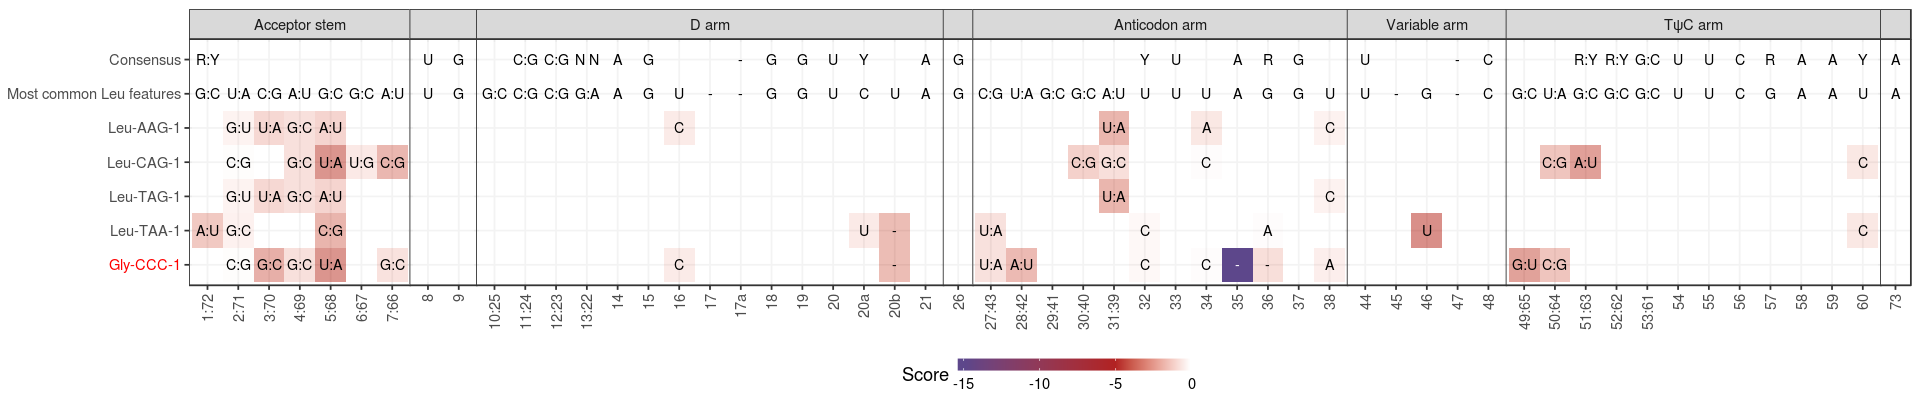

In [52]:
options(repr.plot.width=16, repr.plot.height=3.4)
plot
ggsave(plot, filename = "figS5m-ce-GlyCCC-Leu.pdf", width = 16, height = 3.4, device = cairo_pdf)

## Lys-TTT-7

In [53]:
bits = calculate_scores_multiseq(seqs = c(
'Lys-CTT-1-1' = 'GCCCGGCTAGCTCAGTCGGTAGAGCATGGGACTCTTAATCCCAGGGtCGTGGGTTCGAGCCCCACGTTGGGCG', 
'Lys-CTT-5-1' = 'GCCCGGCTAGCTCAGTCGATAGAGCATGAGACTCTTAATCTCAGGGtCGTGGGTTCGAGCCGCACGTTGGGCG', 
'Lys-TTT-1-1' = 'GCCTGGATAGCTCAGTTGGTAGAGCATCAGACTTTTAATCTGAGGGtCCAGGGTTCAAGTCCCTGTTCAGGCA', 
'Lys-TTT-3-1' = 'GCCCGGATAGCTCAGTCGGTAGAGCATCAGACTTTTAATCTGAGGGtCCAGGGTTCAAGTCCCTGTTCGGGCG', 
'Lys-TTT-4-1' = 'GCCTGGATAGCTCAGTCGGTAGAGCATCAGACTTTTAATCTGAGGGtCCAGGGTTCAAGTCCCTGTTCAGGCG', 
'Lys-TTT-7-1' = 'GCCTGGATAGCTCAGTTGGTAGAACATCAGACTTTTAATCTGACGGtGCAGGGTTCAAGTCCCTGTTCAGGCG'),
                                clade = "", isotype = "Lys", anticodon = "")

In [54]:
plot = bits %>% rowwise() %>% mutate(Identity = ifelse(Consensus == Identity, "", paste(Identity)), Bits = ifelse(Identity == "", 0, Bits)) %>%
  rbind(bits %>% 
          filter(tRNA == tRNA[1]) %>%
          mutate(Identity = Consensus, Bits = 0, tRNA = "Most common Lys features")) %>%
  mutate(tRNA = factor(tRNA, levels = rev(c("Most common Lys features", unique(bits$tRNA))))) %>%
  plot_bitchart + theme(axis.text.y = element_text(color = c("red", "gray30", "gray30", "gray30", "gray30", "gray30", "gray30", "gray30")))

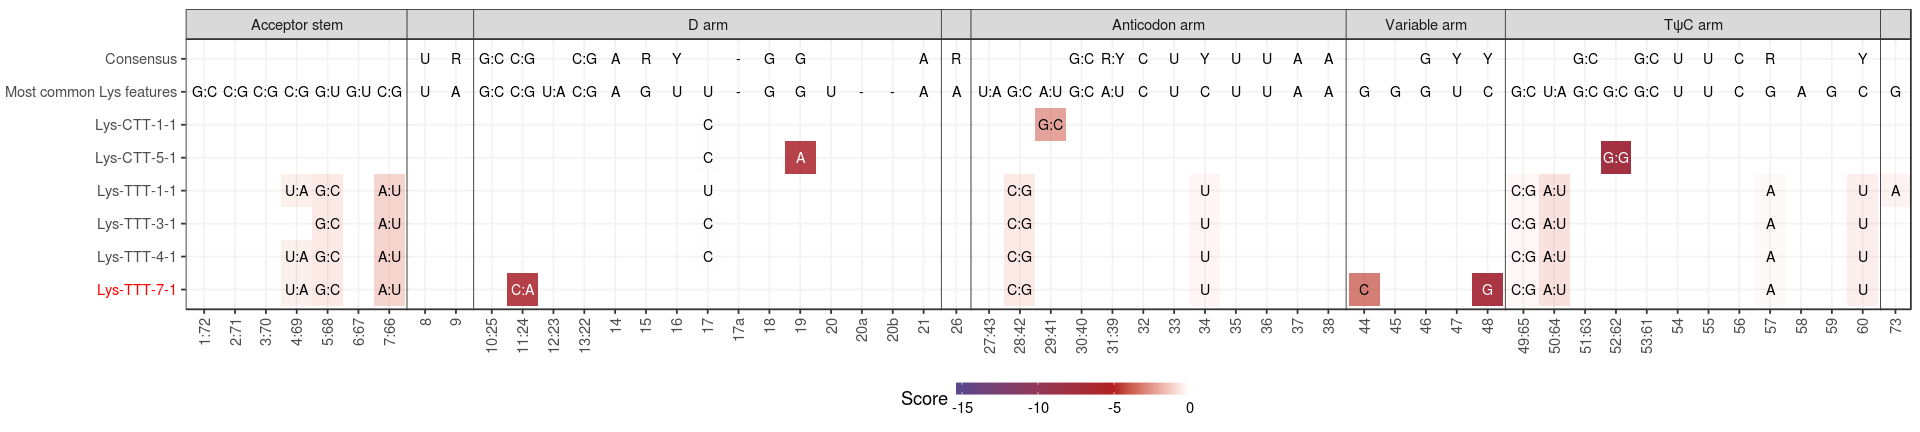

In [55]:
options(repr.plot.width=16, repr.plot.height=3.6)
plot
ggsave(plot, filename = "figS5n-LysTTT.pdf", width = 16, height = 3.6, device = cairo_pdf)

In [56]:
for (current_isotype in isotypes) {
  subset = identities %>% select_('species', 'seqname', 'isotype', 'clade', 'anticodon', 'restrict') %>%
    filter_('!restrict') %>%
    filter(clade == "Mammal", isotype == current_isotype)
  if (dim(subset)[1] < 5) return('Rare anticodon; could not generate consensus')
  euk_seqs = readDNAStringSet(filepath = '/projects/lowelab/users/blin/identity/euk-isotypes/euk-tRNAs.fa', format = 'fasta')
  names(euk_seqs) = str_replace(str_extract(names(euk_seqs), '\\S+'), '\\|', '_')
  writeXStringSet(euk_seqs[match(subset$seqname, names(euk_seqs))], filepath = 'subset.fa')

  # create covariance model
  align = paste0('restrict_cm/', current_isotype, '.sto')
  model = paste0('restrict_cm/', current_isotype, '.cm')
  system(paste0('cmalign -g --notrunc --matchonly -o ', align, ' /projects/lowelab/users/blin/tRNAscan/models/domain-specific/euk-num-092016.cm subset.fa > /dev/null'))
  system(paste0('cmbuild --enone -F ', model, ' ', align, ' > /dev/null'))

  # clean up
  system('rm subset.fa')
}

In [57]:
name_map = read.table('/projects/lowelab/users/blin/data/hg19-tRNAs_name_map.txt', header = TRUE, stringsAsFactors = FALSE)
name_map %>% head

,tRNAscan.SE_id,GtRNAdb_id
1,chr1.trna1,tRNA-Val-CAC-13-1
2,chr1.trna10,tRNA-Asn-GTT-16-1
3,chr1.trna100,tRNA-Asn-GTT-6-1
4,chr1.trna101,tRNA-Asn-GTT-22-1
5,chr1.trna102,tRNA-Glu-TTC-7-1
6,chr1.trna103,tRNA-His-GTG-2-1


In [58]:
identities %>% filter(species == 'hg19', isotype == "Ala") %>% 
  select(seqname, score, X1.72, X2.71, X3.70, X4.69, X5.68, X6.67, X7.66, X8, X9, X10.25, X11.24, X12.23, X13.22, X14, X15, X16, X18, X19, X20, X21, X26, X27.43, X28.42, X29.41, X30.40, X31.39, X32, X33, X34, X35, X36, X37, X38, X44, X45, X46, X47, X48, X49.65, X50.64, X51.63, X52.62, X53.61, X54, X55, X56, X57, X58, X59, X60, X73) %>%
  mutate(seqname = str_extract(as.character(seqname), 'chr\\d+\\.trna\\d+')) %>%
  mutate(seqname = name_map[match(seqname, name_map$tRNAscan.SE_id), ]$GtRNAdb_id) %>%
  arrange(desc(score), seqname) %>%
  kable %>% paste(collapse = '\n') %>% display_markdown

|seqname           | score|X1.72 |X2.71 |X3.70 |X4.69 |X5.68 |X6.67 |X7.66 |X8 |X9 |X10.25 |X11.24 |X12.23 |X13.22 |X14 |X15 |X16 |X18 |X19 |X20 |X21 |X26 |X27.43 |X28.42 |X29.41 |X30.40 |X31.39 |X32 |X33 |X34 |X35 |X36 |X37 |X38 |X44 |X45 |X46 |X47 |X48 |X49.65 |X50.64 |X51.63 |X52.62 |X53.61 |X54 |X55 |X56 |X57 |X58 |X59 |X60 |X73 |
|:-----------------|-----:|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:--|:--|:------|:------|:------|:------|:---|:---|:---|:---|:---|:---|:---|:---|:------|:------|:------|:------|:------|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:---|:------|:------|:------|:------|:------|:---|:---|:---|:---|:---|:---|:---|:---|
|tRNA-Ala-AGC-1-1  |  84.9|G:C   |G:C   |G:U   |G:C   |G:C   |U:A   |A:U   |U  |A  |G:C    |C:G    |U:A    |C:G    |A   |G   |U   |G   |G   |U   |A   |G   |C:G    |G:C    |U:A    |G:C    |C:G    |U   |U   |A   |G   |C   |A   |U   |A   |G   |G   |U   |C   |C:G    |U:A    |G:C    |G:C    |G:C    |U   |U   |C   |G   |A   |U   |C   |A   |
|tRNA-Ala-AGC-2-1  |  84.7|G:C   |G:C   |G:U   |G:C   |G:C   |U:A   |G:C   |U  |A  |G:C    |C:G    |U:A    |C:G    |A   |G   |U   |G   |G   |U   |A   |G   |C:G    |G:C    |U:A    |G:C    |C:G    |U   |U   |A   |G   |C   |A   |U   |A   |G   |G   |C   |C   |C:G    |C:G    |G:C    |G:C    |G:C    |U   |U   |C   |A   |A   |U   |C   |A   |
|tRNA-Ala-AGC-2-2  |  84.7|G:C   |G:C   |G:U   |G:C   |G:C   |U:A   |G:C   |U  |A  |G:C    |C:G    |U:A    |C:G    |A   |G   |U   |G   |G   |U   |A   |G   |C:G    |G:C    |U:A    |G:C    |C:G    |U   |U   |A   |G   |C   |A   |U   |A   |G   |G   |C   |C   |C:G    |C:G    |G:C    |G:C    |G:C    |U   |U   |C   |A   |A   |U   |C   |A   |
|tRNA-Ala-AGC-5-1  |  84.2|G:C   |G:C   |G:U   |G:C   |G:C   |U:A   |G:C   |U  |A  |G:C    |C:G    |U:A    |C:G    |A   |G   |U   |G   |G   |U   |A   |G   |C:G    |G:C    |U:A    |G:C    |C:G    |U   |U   |A   |G   |C   |A   |U   |A   |G   |G   |C   |C   |C:G    |U:A    |G:C    |G:C    |G:C    |U   |U   |C   |A   |A   |U   |C   |A   |
|tRNA-Ala-TGC-1-1  |  80.5|G:C   |G:C   |G:U   |G:C   |G:C   |U:A   |G:C   |U  |A  |G:C    |C:G    |U:A    |C:G    |A   |G   |U   |G   |G   |U   |A   |G   |C:G    |A:U    |U:A    |G:U    |C:G    |U   |U   |U   |G   |C   |A   |U   |A   |G   |G   |U   |C   |C:G    |C:G    |G:C    |G:C    |G:C    |U   |U   |C   |G   |A   |U   |C   |A   |
|tRNA-Ala-AGC-3-1  |  80.3|G:C   |G:C   |G:U   |G:C   |G:C   |U:A   |G:C   |U  |A  |G:C    |C:G    |U:A    |C:G    |A   |G   |U   |G   |G   |U   |A   |G   |C:G    |G:C    |U:A    |G:U    |C:G    |U   |U   |A   |G   |C   |A   |U   |A   |G   |G   |U   |C   |C:G    |C:G    |G:C    |G:C    |G:C    |U   |U   |C   |A   |A   |U   |C   |A   |
|tRNA-Ala-CGC-1-1  |  79.7|G:C   |G:C   |G:U   |G:C   |A:U   |U:A   |G:C   |U  |A  |G:C    |C:G    |U:A    |C:G    |A   |G   |U   |G   |G   |U   |A   |G   |C:G    |A:U    |U:A    |G:U    |C:G    |U   |U   |C   |G   |C   |A   |U   |A   |G   |G   |U   |C   |C:G    |C:G    |G:C    |G:C    |G:C    |U   |U   |C   |G   |A   |U   |C   |A   |
|tRNA-Ala-CGC-2-1  |  79.7|G:C   |G:C   |G:U   |G:C   |A:U   |U:A   |G:C   |U  |A  |G:C    |C:G    |U:A    |C:G    |A   |G   |U   |G   |G   |U   |A   |G   |C:G    |A:U    |U:A    |G:U    |C:G    |U   |U   |C   |G   |C   |A   |U   |A   |G   |G   |C   |C   |C:G    |C:G    |G:C    |G:C    |G:C    |U   |U   |C   |G   |A   |U   |C   |A   |
|tRNA-Ala-TGC-2-1  |  79.7|G:C   |G:C   |G:U   |G:C   |A:U   |U:A   |G:C   |U  |A  |G:C    |C:G    |U:A    |C:G    |A   |G   |U   |G   |G   |U   |A   |G   |C:G    |A:U    |U:A    |G:U    |C:G    |U   |U   |U   |G   |C   |A   |U   |A   |G   |G   |U   |C   |C:G    |C:G    |G:C    |G:C    |G:C    |U   |U   |C   |G   |A   |U   |C   |A   |
|tRNA-Ala-TGC-3-1  |  79.7|G:C   |G:C   |G:U   |G:C   |A:U   |U:A   |G:C   |U  |A  |G:C    |C:G    |U:A    |C:G    |A   |G   |U   |G   |G   |U   |A   |G   |C:G    |A:U    |U:A    |G:U    |C:G    |U   |U   |U   |G   |C   |A   |U   |A   |G   |G   |C   |C   |C:G    |C:G    |G:C    |G:C    |G:C    |U   |U   |C   |G   |A   |U   |C   |A   |
|tRNA-Ala-TGC-3-2  |  79.7|G:C   |G:C   |G:U   |G:C   |A:U   |U:A   |G:C   |U  |A  |G:C    |C:G    |U:A    |C:G    |A   |G   |U   |G   |G   |U   |A   |G   |C:G    |A:U    |U:A    |G:U    |C:G    |U   |U   |U   |G   |C   |A   |U   |A   |G   |G   |C   |C   |C:G    |C:G    |G:C    |G:C    |G:C    |U   |U   |C   |G   |A   |U   |C   |A   |
|tRNA-Ala-TGC-4-1  |  78.8|G:C   |G:C   |G:U   |G:C   |A:U   |U:A   |G:C   |U  |A  |G:C    |C:G    |U:A    |C:G    |A   |G   |U   |G   |G   |U   |A   |G   |C:G    |A:U    |U:A    |G:U    |C:G    |U   |U   |U   |G   |C   |A   |C   |A   |G   |G   |C   |C   |C:G    |C:G    |G:C    |G:C    |G:C    |U   |U   |C   |A   |A   |U   |C   |A   |
|tRNA-Ala-AGC-7-1  |  78.5|G:C   |G:C   |G:U   |G:C   |G:C   |U:A   |G:C   |U  |A  |G:C    |C:G    |U:A    |C:G    |A   |G   |U   |G   |G   |U   |A   |G   |C:G    |G:C    |U:A    |G:C    |C:G    |U   |U   |A   |G   |C   |A   |U   |A   |G   |G   |C   |C   |C:G    |C:G    |G:U    |G:C    |G:C    |U   |U   |C   |A   |A   |U   |C   |A   |
|tRNA-Ala-AGC-4-1  |  76.1|G:C   |G:C   |G:U   |G:C   |A:U   |U:A   |G:C   |U  |A  |G:C    |C:G    |U:A    |C:G    |A   |G   |U   |G   |G   |U   |A   |G   |C:G    |A:U    |U:A    |G:C    |C:G    |U   |U   |A   |G   |C   |A   |U   |A   |G   |G   |U   |C   |C:G    |C:A    |G:C    |G:C    |G:C    |U   |U   |C   |G   |A   |U   |C   |A   |
|tRNA-Ala-CGC-4-1  |  76.1|G:C   |G:C   |G:U   |G:C   |G:C   |U:U   |G:C   |U  |A  |G:C    |C:G    |U:A    |C:G    |A   |G   |U   |G   |G   |U   |A   |G   |C:G    |G:C    |U:A    |G:U    |C:G    |U   |U   |C   |G   |C   |A   |U   |A   |G   |G   |C   |C   |C:G    |C:G    |G:C    |G:C    |G:C    |U   |U   |C   |G   |A   |C   |C   |A   |
|tRNA-Ala-TGC-5-1  |  75.3|G:C   |G:C   |G:U   |G:C   |G:C   |U:A   |G:C   |U  |A  |G:C    |C:G    |U:A    |C:G    |A   |G   |U   |G   |G   |U   |A   |G   |C:G    |A:U    |U:A    |G:U    |C:G    |U   |U   |U   |G   |C   |A   |U   |A   |G   |G   |C   |C   |U:A    |C:G    |G:C    |G:C    |G:C    |U   |U   |C   |G   |A   |U   |C   |A   |
|tRNA-Ala-CGC-3-1  |  74.4|G:C   |G:C   |G:U   |G:C   |A:U   |U:A   |G:C   |U  |A  |G:C    |C:G    |U:A    |C:G    |A   |G   |U   |G   |G   |U   |A   |G   |C:G    |G:U    |C:G    |G:U    |C:G    |U   |U   |C   |G   |C   |A   |U   |A   |G   |G   |U   |C   |C:G    |C:G    |G:C    |G:C    |G:C    |U   |U   |C   |A   |A   |U   |C   |A   |
|tRNA-Ala-TGC-6-1  |  74.2|G:C   |G:C   |G:U   |G:C   |G:C   |U:A   |G:C   |U  |A  |G:C    |C:G    |U:A    |C:G    |A   |G   |U   |G   |G   |U   |A   |A   |C:G    |A:U    |U:G    |G:U    |C:G    |U   |U   |U   |G   |C   |A   |U   |A   |G   |G   |C   |C   |C:G    |C:G    |G:C    |G:C    |G:C    |U   |U   |C   |G   |A   |U   |C   |A   |
|tRNA-Ala-AGC-6-1  |  74.1|G:C   |G:C   |G:U   |G:C   |G:C   |U:A   |A:U   |U  |A  |G:C    |C:G    |U:A    |C:G    |A   |G   |C   |G   |G   |U   |A   |G   |C:G    |G:C    |U:A    |G:C    |C:G    |U   |U   |A   |G   |C   |A   |U   |A   |G   |G   |U   |C   |C:A    |U:A    |G:C    |G:C    |G:C    |U   |U   |C   |A   |A   |U   |C   |A   |
|tRNA-Ala-AGC-10-1 |  60.1|G:C   |G:C   |G:U   |G:C   |A:U   |A:U   |U:A   |U  |A  |G:C    |C:G    |U:A    |C:G    |A   |A   |G   |G   |G   |U   |A   |G   |C:G    |U:A    |U:A    |G:C    |C:G    |U   |U   |A   |G   |C   |A   |C   |A   |G   |G   |U   |A   |G:C    |U:A    |G:C    |G:C    |G:C    |A   |U   |C   |G   |A   |U   |G   |A   |
|tRNA-Ala-AGC-12-1 |  60.0|G:C   |G:C   |G:U   |G:C   |A:U   |A:U   |U:A   |U  |A  |G:C    |C:G    |U:A    |C:G    |A   |A   |G   |G   |G   |U   |A   |G   |C:G    |U:A    |U:A    |G:C    |C:G    |U   |U   |A   |G   |C   |A   |U   |A   |G   |G   |U   |A   |G:C    |U:A    |G:C    |G:C    |G:C    |A   |U   |C   |G   |A   |U   |G   |A   |
|tRNA-Ala-AGC-12-2 |  60.0|G:C   |G:C   |G:U   |G:C   |A:U   |A:U   |U:A   |U  |A  |G:C    |C:G    |U:A    |C:G    |A   |A   |G   |G   |G   |U   |A   |G   |C:G    |U:A    |U:A    |G:C    |C:G    |U   |U   |A   |G   |C   |A   |U   |A   |G   |G   |U   |A   |G:C    |U:A    |G:C    |G:C    |G:C    |A   |U   |C   |G   |A   |U   |G   |A   |
|tRNA-Ala-AGC-12-3 |  60.0|G:C   |G:C   |G:U   |G:C   |A:U   |A:U   |U:A   |U  |A  |G:C    |C:G    |U:A    |C:G    |A   |A   |G   |G   |G   |U   |A   |G   |C:G    |U:A    |U:A    |G:C    |C:G    |U   |U   |A   |G   |C   |A   |U   |A   |G   |G   |U   |A   |G:C    |U:A    |G:C    |G:C    |G:C    |A   |U   |C   |G   |A   |U   |G   |A   |
|tRNA-Ala-TGC-7-1  |  60.0|G:C   |G:C   |G:U   |G:C   |G:C   |U:A   |G:C   |U  |A  |G:C    |C:G    |U:A    |C:G    |A   |G   |U   |G   |G   |U   |A   |G   |C:G    |A:U    |U:A    |G:U    |C:G    |U   |U   |U   |G   |C   |A   |U   |A   |G   |G   |-   |C   |C:A    |U:G    |C:C    |G:C    |G:C    |U   |U   |C   |G   |A   |U   |C   |A   |
|tRNA-Ala-AGC-8-1  |  59.7|G:C   |G:C   |G:U   |G:C   |G:C   |A:U   |U:A   |U  |A  |G:C    |C:G    |U:A    |C:G    |A   |A   |A   |G   |G   |U   |A   |G   |C:G    |U:A    |C:G    |G:C    |C:G    |U   |U   |A   |G   |C   |A   |U   |A   |G   |G   |U   |A   |G:C    |C:G    |G:C    |G:C    |G:C    |A   |U   |C   |G   |A   |U   |G   |A   |
|tRNA-Ala-AGC-8-2  |  59.7|G:C   |G:C   |G:U   |G:C   |G:C   |A:U   |U:A   |U  |A  |G:C    |C:G    |U:A    |C:G    |A   |A   |A   |G   |G   |U   |A   |G   |C:G    |U:A    |C:G    |G:C    |C:G    |U   |U   |A   |G   |C   |A   |U   |A   |G   |G   |U   |A   |G:C    |C:G    |G:C    |G:C    |G:C    |A   |U   |C   |G   |A   |U   |G   |A   |
|tRNA-Ala-AGC-11-1 |  58.9|G:C   |G:C   |G:U   |G:C   |A:U   |A:U   |U:A   |U  |A  |G:C    |C:G    |U:A    |C:G    |A   |A   |A   |G   |G   |U   |A   |G   |C:G    |U:A    |C:G    |G:C    |C:G    |U   |U   |A   |G   |C   |A   |U   |A   |G   |G   |U   |A   |G:C    |C:G    |G:C    |G:C    |G:C    |A   |U   |C   |G   |A   |U   |G   |A   |
|tRNA-Ala-AGC-14-1 |  58.9|G:C   |G:C   |G:U   |G:C   |A:U   |A:U   |U:A   |U  |A  |G:C    |C:G    |U:A    |C:G    |A   |A   |G   |G   |G   |U   |A   |G   |C:G    |U:A    |U:A    |G:C    |C:G    |U   |U   |A   |G   |C   |A   |U   |A   |G   |G   |U   |A   |G:C    |U:A    |G:C    |G:C    |G:C    |A   |U   |C   |A   |A   |U   |G   |A   |
|tRNA-Ala-AGC-13-1 |  58.7|G:C   |G:C   |G:U   |G:C   |A:U   |A:U   |U:A   |U  |A  |G:C    |C:G    |U:A    |C:G    |A   |A   |G   |G   |G   |U   |A   |G   |C:G    |U:A    |U:A    |G:C    |C:G    |U   |U   |A   |G   |C   |A   |U   |A   |G   |G   |U   |A   |G:C    |U:A    |G:C    |G:C    |G:C    |A   |U   |C   |G   |A   |U   |G   |A   |
|tRNA-Ala-AGC-13-2 |  58.7|G:C   |G:C   |G:U   |G:C   |A:U   |A:U   |U:A   |U  |A  |G:C    |C:G    |U:A    |C:G    |A   |A   |G   |G   |G   |U   |A   |G   |C:G    |U:A    |U:A    |G:C    |C:G    |U   |U   |A   |G   |C   |A   |U   |A   |G   |G   |U   |A   |G:C    |U:A    |G:C    |G:C    |G:C    |A   |U   |C   |G   |A   |U   |G   |A   |
|tRNA-Ala-AGC-9-1  |  58.3|G:C   |G:C   |G:U   |G:C   |A:U   |A:U   |U:A   |U  |A  |G:C    |C:G    |U:A    |C:G    |A   |G   |G   |G   |G   |U   |A   |G   |C:G    |U:A    |C:G    |G:C    |C:G    |U   |U   |A   |G   |C   |A   |U   |A   |G   |G   |U   |A   |G:C    |C:G    |G:C    |G:C    |G:C    |A   |U   |C   |G   |A   |C   |G   |A   |
|tRNA-Ala-AGC-9-2  |  58.3|G:C   |G:C   |G:U   |G:C   |A:U   |A:U   |U:A   |U  |A  |G:C    |C:G    |U:A    |C:G    |A   |G   |G   |G   |G   |U   |A   |G   |C:G    |U:A    |C:G    |G:C    |C:G    |U   |U   |A   |G   |C   |A   |U   |A   |G   |G   |U   |A   |G:C    |C:G    |G:C    |G:C    |G:C    |A   |U   |C   |G   |A   |C   |G   |A   |
|tRNA-Ala-AGC-15-1 |  56.7|G:C   |G:C   |G:U   |G:C   |A:U   |A:U   |U:A   |U  |A  |G:C    |C:G    |U:A    |C:G    |A   |A   |G   |G   |G   |U   |A   |G   |C:G    |U:A    |C:G    |G:C    |C:G    |U   |U   |A   |G   |C   |A   |U   |A   |G   |G   |U   |A   |G:C    |U:G    |G:C    |G:C    |G:C    |A   |U   |C   |G   |A   |U   |G   |A   |

In [59]:
bits = calculate_scores_multiseq(seqs = c(
'tRNA-Leu-AAG-1-1' = 'GGTAGCGTGGCCGAGCGGTctAAGGCGCTGGATTAAGGCTCCAGTCTCTTCGGAGGCGTGGGTTCGAATCCCACCGCTGCCA', 'tRNA-Leu-AAG-1-2' = 'GGTAGCGTGGCCGAGCGGTctAAGGCGCTGGATTAAGGCTCCAGTCTCTTCGGAGGCGTGGGTTCGAATCCCACCGCTGCCA', 'tRNA-Leu-AAG-1-3' = 'GGTAGCGTGGCCGAGCGGTctAAGGCGCTGGATTAAGGCTCCAGTCTCTTCGGAGGCGTGGGTTCGAATCCCACCGCTGCCA', 'tRNA-Leu-AAG-2-1' = 'GGTAGCGTGGCCGAGCGGTctAAGGCGCTGGATTAAGGCTCCAGTCTCTTCGGGGGCGTGGGTTCGAATCCCACCGCTGCCA', 'tRNA-Leu-AAG-2-2' = 'GGTAGCGTGGCCGAGCGGTctAAGGCGCTGGATTAAGGCTCCAGTCTCTTCGGGGGCGTGGGTTCGAATCCCACCGCTGCCA', 'tRNA-Leu-AAG-2-3' = 'GGTAGCGTGGCCGAGCGGTctAAGGCGCTGGATTAAGGCTCCAGTCTCTTCGGGGGCGTGGGTTCGAATCCCACCGCTGCCA', 'tRNA-Leu-AAG-2-4' = 'GGTAGCGTGGCCGAGCGGTctAAGGCGCTGGATTAAGGCTCCAGTCTCTTCGGGGGCGTGGGTTCGAATCCCACCGCTGCCA', 'tRNA-Leu-AAG-3-1' = 'GGTAGCGTGGCCGAGCGGTctAAGGCGCTGGATTAAGGCTCCAGTCTCTTCGGGGGCGTGGGTTCAAATCCCACCGCTGCCA', 'tRNA-Leu-AAG-4-1' = 'GGTAGCGTGGCCGAGTGGTctAAGACGCTGGATTAAGGCTCCAGTCTCTTCGGGGGCGTGGGTTTGAATCCCACCGCTGCCA', 'tRNA-Leu-CAG-1-1' = 'GTCAGGATGGCCGAGCGGTctAAGGCGCTGCGTTCAGGTCGCAGTCTCCCCTGGAGGCGTGGGTTCGAATCCCACTCCTGACA', 'tRNA-Leu-CAG-1-2' = 'GTCAGGATGGCCGAGCGGTctAAGGCGCTGCGTTCAGGTCGCAGTCTCCCCTGGAGGCGTGGGTTCGAATCCCACTCCTGACA', 'tRNA-Leu-CAG-1-3' = 'GTCAGGATGGCCGAGCGGTctAAGGCGCTGCGTTCAGGTCGCAGTCTCCCCTGGAGGCGTGGGTTCGAATCCCACTCCTGACA', 'tRNA-Leu-CAG-1-4' = 'GTCAGGATGGCCGAGCGGTctAAGGCGCTGCGTTCAGGTCGCAGTCTCCCCTGGAGGCGTGGGTTCGAATCCCACTCCTGACA', 'tRNA-Leu-CAG-1-5' = 'GTCAGGATGGCCGAGCGGTctAAGGCGCTGCGTTCAGGTCGCAGTCTCCCCTGGAGGCGTGGGTTCGAATCCCACTCCTGACA', 'tRNA-Leu-CAG-1-6' = 'GTCAGGATGGCCGAGCGGTctAAGGCGCTGCGTTCAGGTCGCAGTCTCCCCTGGAGGCGTGGGTTCGAATCCCACTCCTGACA', 'tRNA-Leu-CAG-1-7' = 'GTCAGGATGGCCGAGCGGTctAAGGCGCTGCGTTCAGGTCGCAGTCTCCCCTGGAGGCGTGGGTTCGAATCCCACTCCTGACA', 'tRNA-Leu-CAG-2-1' = 'GTCAGGATGGCCGAGCGGTctAAGGCGCTGCGTTCAGGTCGCAGTCTCCCCTGGAGGCGTGGGTTCGAATCCCACTTCTGACA', 'tRNA-Leu-CAG-2-2' = 'GTCAGGATGGCCGAGCGGTctAAGGCGCTGCGTTCAGGTCGCAGTCTCCCCTGGAGGCGTGGGTTCGAATCCCACTTCTGACA', 'tRNA-Leu-TAG-1-1' = 'GGTAGCGTGGCCGAGCGGTctAAGGCGCTGGATTTAGGCTCCAGTCTCTTCGGAGGCGTGGGTTCGAATCCCACCGCTGCCA', 'tRNA-Leu-TAG-2-1' = 'GGTAGTGTGGCCGAGCGGTctAAGGCGCTGGATTTAGGCTCCAGTCTCTTCGGGGGCGTGGGTTCGAATCCCACCACTGCCA', 'tRNA-Leu-TAG-3-1' = 'GGTAGCGTGGCCGAGTGGTctAAGGCGCTGGATTTAGGCTCCAGTCATTTCGATGGCGTGGGTTCGAATCCCACCGCTGCCA', 'tRNA-Leu-CAA-2-1' = 'GTCAGGATGGCCGAGTGGTctAAGGCGCCAGACTCAAGcttactgcttcctgtgttcgggtcTTCTGGTCTCCGTATGGAGGCGTGGGTTCGAATCCCACTTCTGACA', 'tRNA-Leu-CAA-3-1' = 'GTCAGGATGGCCGAGTGGTctAAGGCGCCAGACTCAAGttgctacttcccaggtttggggcTTCTGGTCTCCGCATGGAGGCGTGGGTTCGAATCCCACTTCTGACA', 'tRNA-Leu-CAA-1-1' = 'GTCAGGATGGCCGAGTGGTctAAGGCGCCAGACTCAAGctaagcttcctccgcggtggggaTTCTGGTCTCCAATGGAGGCGTGGGTTCGAATCCCACTTCTGACA', 'tRNA-Leu-CAA-1-2' = 'GTCAGGATGGCCGAGTGGTctAAGGCGCCAGACTCAAGcttggcttcctcgtgttgaggaTTCTGGTCTCCAATGGAGGCGTGGGTTCGAATCCCACTTCTGACA', 'tRNA-Leu-CAA-4-1' = 'GTCAGGATGGCCGAGTGGTctAAGGCGCCAGACTCAAGgtaagcaccttgcctgcgggctTTCTGGTCTCCGGATGGAGGCGTGGGTTCGAATCCCACTTCTGACA', 'tRNA-Leu-CAA-5-1' = 'GCCTCCTTAGTGCAGTAGGTAGCGCATCAGTCTCAAAATCTGAAtGGtCCTGAGTTCAAGCCTCAGAGGGGGCA', 'tRNA-Leu-CAA-6-1' = 'GTCAGGATGGCCGAGCAGTcttAAGGCGCTGCGTTCAAATCGCACCCTCCGCTGGAGGCGTGGGTTCGAATCCCACTTTTGACA', 'tRNA-Leu-TAA-2-1' = 'ACCGGGATGGCCGAGTGGTtAAGGCGTTGGACTTAAGATCCAATGGGCTGGTGCCCGCGTGGGTTCGAACCCCACTCTCGGTA', 'tRNA-Leu-TAA-1-1' = 'ACCAGGATGGCCGAGTGGTtAAGGCGTTGGACTTAAGATCCAATGGACATATGTCCGCGTGGGTTCGAACCCCACTCCTGGTA', 'tRNA-Leu-TAA-3-1' = 'ACCAGAATGGCCGAGTGGTtAAGGCGTTGGACTTAAGATCCAATGGATTCATATCCGCGTGGGTTCGAACCCCACTTCTGGTA', 'tRNA-Leu-TAA-4-1' = 'ACCGGGATGGCTGAGTGGTtAAGGCGTTGGACTTAAGATCCAATGGACAGGTGTCCGCGTGGGTTCGAGCCCCACTCCCGGTA'), 
                                 clade = "", isotype = "Leu", anticodon = "")

In [60]:
plot = bits %>% rowwise() %>% mutate(Identity = ifelse(Consensus == Identity, "", paste(Identity)), Bits = ifelse(Identity == "", 0, Bits)) %>%
  rbind(bits %>% 
          filter(tRNA == tRNA[1]) %>%
          mutate(Identity = Consensus, Bits = 0, tRNA = "Most common Leu features")) %>%
  mutate(tRNA = factor(tRNA, levels = rev(c("Most common Leu features", unique(bits$tRNA))))) %>%
  plot_bitchart

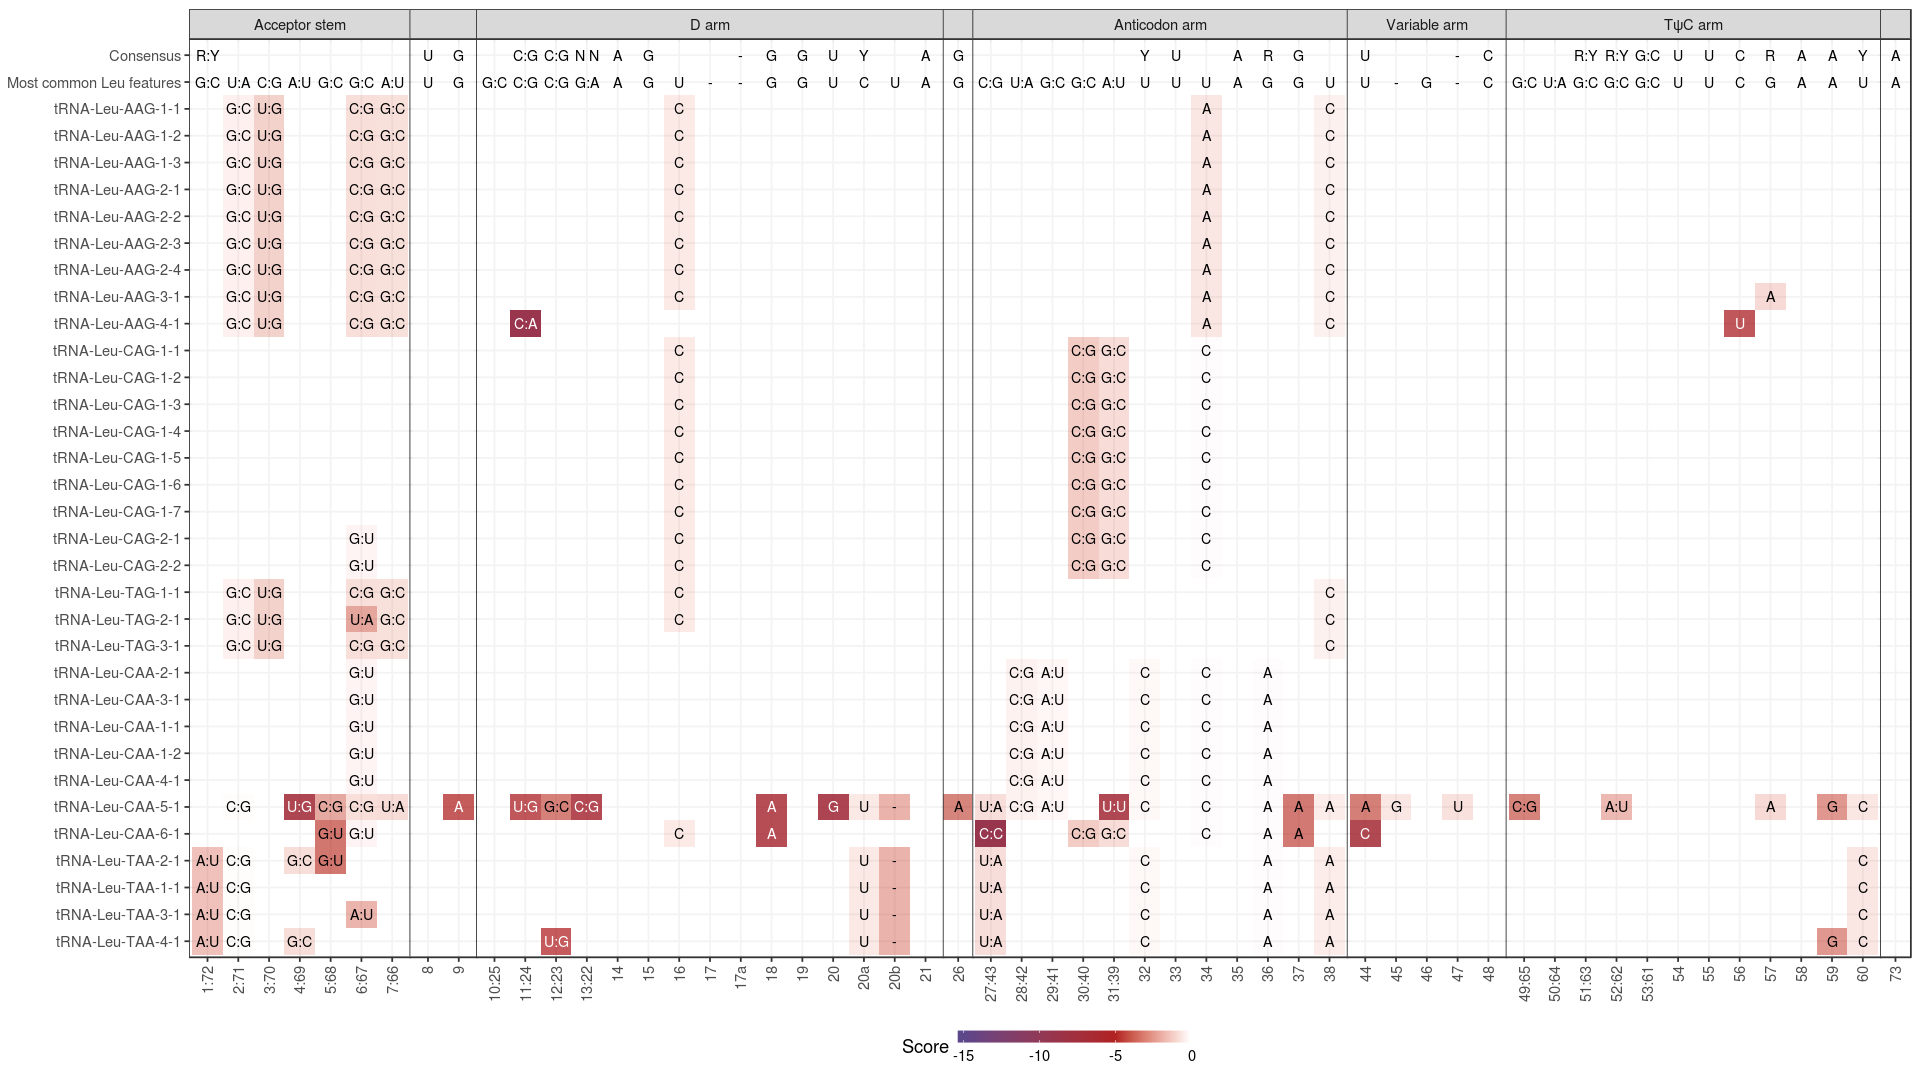

In [61]:
options(repr.plot.width=16, repr.plot.height=9)
plot